# COMP5046 Assignment2 

Authors:
- Xinyue Wang (440359463)
- Xiang Zhou (490622328)

Both authors made equal contribution to this assignment.

## Read ME

This notebook demonstrate Name Entity Recognisition task with part of conll2003 dataset. It covers input embedding, model design, evaluation and analysis sections.

### Structure

1. Data preprocessing
2. Input embedding - implementation
  a. Word2Vec
  b. POS tag
  c.TF-IDF
  d.ELMo

3. NER model - archietecture design and implementation
  a. ElMo Bi-LSTM Attention model
  b. Bi-LSTM CRF model

4. Evaluation - justification on input embedding selection, model design and parameter choices.

### Complication Notes

1. Please run the next few `pip install` commands and then restart the session since we requires a `1.x` version of `tensorflow` while the default version of pre-installed `tensorflow` is `2.x`

2. Please run cells in order since there are dependencies in cells.

3. Please make sure the train, validation and test datasets are in the root folder of your Google Drive i.e. `drive/My Drive/`. This might ask for temporary credentials to authorise the code compilation.

4. In section 3, only best model training log is available which you can find in the Optimal model subsection.

5. Detailed evaluation logs are available in section 4 which justifies the optimal model shown in section3.

6. You can use submitted best model to predict on test set, which you can find in section 4.1.4.

In [0]:

!pip install tensorflow==1.15

In [0]:
!pip install keras-self-attention

In [0]:
!pip3 install h5py

In [0]:
!pip freeze | grep tensorflow

tensorflow==1.15.0
tensorflow-addons==0.8.3
tensorflow-datasets==2.1.0
tensorflow-estimator==1.15.1
tensorflow-gcs-config==2.1.8
tensorflow-hub==0.8.0
tensorflow-metadata==0.22.1
tensorflow-privacy==0.2.2
tensorflow-probability==0.10.0


In [0]:
import datetime
import numpy as np
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as pl
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras_self_attention import SeqSelfAttention

Using TensorFlow backend.


## 1.Load Data

In this section, we load train, validation and test data from Google Drive.

In [0]:
from google.colab import drive
drive.mount('/content/drive')
df_train = pd.read_csv('/content/drive/My Drive/train.csv')
df_test= pd.read_csv('/content/drive/My Drive/test.csv')
df_val= pd.read_csv('/content/drive/My Drive/val.csv')
df_train.head(10)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Sentence,NER
0,-docstart-,O
1,eu rejects german call to boycott british lamb .,I-ORG O I-MISC O O O I-MISC O O
2,peter blackburn,I-PER I-PER
3,brussels 1996-08-22,I-LOC O
4,the european commission said on thursday it di...,O I-ORG I-ORG O O O O O O I-MISC O O O O O I-M...
5,germany 's representative to the european unio...,I-LOC O O O O I-ORG I-ORG O O O I-PER I-PER O ...
6,""" we do n't support any such recommendation be...",O O O O O O O O O O O O O O O O O O O O I-ORG ...
7,he said further scientific study was required ...,O O O O O O O O O O O O O O O O O O O O O O I-...
8,he said a proposal last month by eu farm commi...,O O O O O O O I-ORG O O I-PER I-PER O O O O O ...
9,fischler proposed eu-wide measures after repor...,I-PER O I-MISC O O O O I-LOC O I-LOC O O O O O...


## 2.Data Processing and Insight Analysis

In this section, we do some processing to dataset including:

1. Split sentence and NER by space
2. Build a vocabulary - `word_to_ix` which assigns all words in train, validation and test integer indices for later input embedding construction

Also some insight analysis is conducted including:

1. NER tag distrbution


In [0]:
train_data=[sentence.split() for sentence in df_train.Sentence]
target_y_train=[sentence.split() for sentence in df_train.NER]

test_data=[sentence.split() for sentence in df_test.Sentence]
# target_y_test=[sentence.split() for sentence in df_test.NER]  # all NANs

validation_data=[sentence.split() for sentence in df_val.Sentence]
target_y_validation=[sentence.split() for sentence in df_val.NER]

In [0]:
word_to_ix = {}
for sentence in train_data+validation_data+test_data:
    for word in sentence:
        word = word.lower()
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
word_list = list(word_to_ix.keys())

START_TAG = "<START>"
STOP_TAG = "<STOP>"
tag_to_ix = {START_TAG:0, STOP_TAG:1}
for tags in target_y_train+target_y_validation:
    for tag in tags:
        if tag not in tag_to_ix:
            tag_to_ix[tag] = len(tag_to_ix)

# quick check
print('Word list length: ',len(word_list))
print(tag_to_ix)
for i, (key, val) in enumerate(word_to_ix.items()):
  if i > 10:
    break
  print(key, val)

Word list length:  13972
{'<START>': 0, '<STOP>': 1, 'O': 2, 'I-ORG': 3, 'I-MISC': 4, 'I-PER': 5, 'I-LOC': 6}
-docstart- 0
eu 1
rejects 2
german 3
call 4
to 5
boycott 6
british 7
lamb 8
. 9
peter 10


In [0]:
def to_index(data, to_ix):
    input_index_list = []
    for sent in data:
        input_index_list.append([to_ix[w] for w in sent])
    return input_index_list

train_input_index =  to_index(train_data,word_to_ix)
train_output_index = to_index(target_y_train,tag_to_ix)
val_input_index = to_index(validation_data,word_to_ix)
val_output_index = to_index(target_y_validation,tag_to_ix)
test_input_index = to_index(test_data,word_to_ix)

# quick check
print(train_input_index[1])
print(train_output_index[1])

[1, 2, 3, 4, 5, 6, 7, 8, 9]
[3, 2, 4, 2, 2, 2, 4, 2, 2]


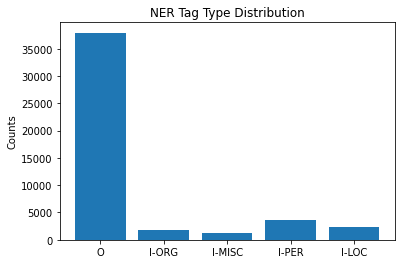

In [0]:
# distribution of labels
import matplotlib.pyplot as pl
from collections import Counter

all_tags = []
for tags in target_y_train+target_y_validation:
  all_tags += tags

counter = Counter(all_tags)
tag_types = list(counter.keys())
tag_counts = list(counter.values())

pl.bar(range(len(tag_types)), tag_counts)
pl.xticks(range(len(tag_types)), tag_types)
pl.ylabel('Counts')
pl.title('NER Tag Type Distribution')
pl.show()

We found there are 5 unique NER tags in the dataset and that the distribution of NER tags are not uniform. Majority of NER tags are "Others". This can create challenges in the model training since the classes are not balanced.


## 3.Input Embeddings

In this section, we implement 3 different types of input embeddings:

1. Word to vec embedding
2. POS tag embedding
3. TF-IDF embedding

The embeddings help project each words into a rich feature space for NER model to learn to best predict the NER tags as accurately as possible. 

We will experiment different combinations of input embeddings and adopt the one gives best result.


### 3.1 Word2Vec Embedding

Here we use the pre-trained word embedding: `glove-twitter-25`.


In [0]:
import gensim.downloader as api
from tqdm.notebook import tqdm

word_emb_model = api.load("glove-twitter-25") 

WORD_EMBEDDING_DIM = 25

word_embedding_matrix = []
for word in tqdm(word_list):
    try:
        word_embedding_matrix.append(word_emb_model.wv[word])
    except:
        word_embedding_matrix.append([0]*WORD_EMBEDDING_DIM)
word_embedding_matrix = np.array(word_embedding_matrix)

# quick check embedding size
print(f'Word embedding matrix shape = {word_embedding_matrix.shape}')

[====================================--------------] 73.9% 77.4/104.8MB downloaded


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL



Word embedding matrix shape = (13972, 25)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # This is added back by InteractiveShellApp.init_path()


### 3.2 POS Tag Embedding

Part-of-Speech (POS) is a class of words based on the word's function, they way it works in a sentence.

Having this tag might help the NER model to predict the labels accurately. In this section, we will create POST tag embedding for our vocabulary. 

Note that the final POS tag embedding would be a matrix of size 

```
(vocabulary_size, num_pos_tags)
```

i.e. the POS tag of each word will be one-hot encoded so that each vector is 0-1 vector where 1 refers to the index of the pos tag and all zeros elsewhere.

In [0]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [0]:
word_pos_tag = {}
for word in tqdm(word_list):
  word_pos_tag[word] = nltk.pos_tag(word)[0][-1]


There are 20 kinds of POS tags


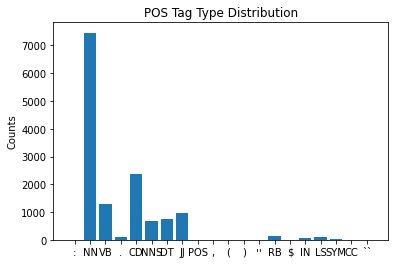

In [0]:
def draw_pos_barchart(word_pos_tag):
  """Visualize the POS tag distribution."""
  all_pos_tags = list(word_pos_tag.values())
  counter = Counter(all_pos_tags)

  tag_types = list(counter.keys())
  tag_counts = list(counter.values())
  print(f'There are {len(tag_types)} kinds of POS tags')
  pl.bar(range(len(tag_types)), tag_counts)
  pl.xticks(range(len(tag_types)), tag_types)
  pl.ylabel('Counts')
  pl.title('POS Tag Type Distribution')
  pl.show()

draw_pos_barchart(word_pos_tag)

#### 3.2.1 Clean POS tags

From the bar chart above we can see there are some invalid pos tags such as following symbols:
```
'$', "''", '(', ')', ',', '.', ':', '``'
```
We need to clean the POS tags a bit to build a good POS tag embedding.


There are 13 kinds of POS tags


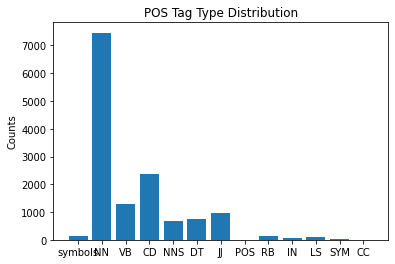

In [0]:
invalid_pos_tags = ['$', "''", '(', ')', ',', '.', ':', '``']
word_pos_tag = {}
for word in tqdm(word_list):
  tag = nltk.pos_tag(word)[0][-1]
  if tag in invalid_pos_tags:
    tag = 'symbols'
  word_pos_tag[word] = tag
draw_pos_barchart(word_pos_tag)

#### 3.2.2 Onehot Encode POS Tag 

In [0]:
pos_tag_to_index = {}
for i, tag in enumerate(set(word_pos_tag.values())):
  pos_tag_to_index[tag] = i
pos_tag_size = len(pos_tag_to_index)
pos_tag_to_index

{'CC': 6,
 'CD': 9,
 'DT': 5,
 'IN': 11,
 'JJ': 10,
 'LS': 8,
 'NN': 12,
 'NNS': 3,
 'POS': 7,
 'RB': 2,
 'SYM': 1,
 'VB': 0,
 'symbols': 4}

In [0]:
pos_embedding_matrix = []
for word in tqdm(word_list):
  pos_vector = [0] * pos_tag_size
  pos_tag = word_pos_tag[word]
  pos_tag_index = pos_tag_to_index[pos_tag]
  pos_vector[pos_tag_index] = 1
  pos_embedding_matrix.append(pos_vector)
pos_embedding_matrix = np.array(pos_embedding_matrix)
print(f'POS Tag Embedding dimension={pos_embedding_matrix.shape}')


POS Tag Embedding dimension=(13972, 13)


### 3.3 TF-IDF Embedding
Tf means term-frequency while tf-idf means term-frequency times inverse document-frequency. This is a common term weighting scheme in information retrieval, that has also found good use in document classification.

Note that the final POS tag embedding would be a matrix of size

```
(vocabulary_size, 1)
```

In [0]:
from sklearn.feature_extraction.text import CountVectorizer  
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.pipeline import Pipeline

# get corpus
corpus = df_train['Sentence'].tolist() + df_test['Sentence'].tolist() \
  + df_val['Sentence'].tolist()

# get tfidf score
pipe = Pipeline([('count', CountVectorizer(vocabulary=word_list)),
                 ('tfid', TfidfTransformer())]).fit(corpus)

tfidf_embedding = pipe['tfid'].idf_.reshape(-1, 1)
print(f'TF-IDF Embedding dimension={tfidf_embedding.shape}')

TF-IDF Embedding dimension=(13972, 1)


### 3.4 Modulise Input Embedding

In this section, we modulise the construction of input embedding where the selection of above 3 input embedding is decided when initalise this embedding object.

In [0]:
class InputEmbedding:

  def __init__(self, use_word2vec, use_pos, use_tfidf):
    """Initialise an input embedding given selections of embedding types

    Parameter
    ---------
    use_word2vec: bool
    use_pos: bool
    use_tfidf: bool
    """
    assert any([use_word2vec, use_pos, use_tfidf])
    self.dim = 0
    self.matrix = []

    if use_word2vec:
      self.dim += word_embedding_matrix.shape[-1]
      self.matrix.append(word_embedding_matrix)
    if use_pos:
      self.dim += pos_embedding_matrix.shape[-1]
      self.matrix.append(pos_embedding_matrix)
    if use_tfidf:
      self.dim += tfidf_embedding.shape[-1]
      self.matrix.append(tfidf_embedding)    

    self.matrix = np.concatenate(self.matrix, axis=-1)
    assert self.dim == self.matrix.shape[-1]

# here we use 1 types of input embeddings
embedding = InputEmbedding(use_word2vec=True, use_pos=True, use_tfidf=True)
embedding_dim = embedding.dim
embedding_matrix = embedding.matrix
print(f'Input Embedding Dimension={embedding_matrix.shape}')

Input Embedding Dimension=(13972, 39)


## 4.NER Model

### 4.1 ELMo Bi-LSTM

ELMo embeddings are embeddings from a language model trained on the 1 Billion Word Benchmark and the pretrained version is available on tensorflow hub.


ELMos use a pre-trained, multi-layer, bi-directional, LSTM-based language model and extract the hidden state of each layer for the input sequence of words. Then, they compute a weighted sum of those hidden states to obtain an embedding for each word. The weight of each hidden state is task-dependent and is learned.

The code below references the demo code in this [blog](https://www.depends-on-the-definition.com/named-entity-recognition-with-residual-lstm-and-elmo/) and the idea comes from this [paper](https://arxiv.org/pdf/1903.07785v1.pdf).

#### 4.1.1 Process Data

In [0]:
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
import h5py
import tensorflow as tf
import tensorflow_hub as hub
from keras import backend as K
from keras.models import Model, Input
from keras.layers.merge import add
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda


##### 4.1.1.1 Determine Maximum Sentence Length

In [0]:
# obtain maximum length of each sentence in whole cohorts - train, test and validation
max_len = 0
for seq in train_data + test_data + validation_data:
  if len(seq) > max_len:
    max_len = len(seq)
max_len

124

##### 4.1.1.2 Add Padding to Sentence and NER Tags

In [0]:
# note batch size much be dividable by number of samples in train and validation
batch_size = 20
n_tags = len(tag_to_ix)

# add padding words to each sentences 
def add_padding_X(data):
  new_X = []
  for seq in data:
    new_seq = []
    for i in range(max_len):
      try: 
        new_seq.append(seq[i])
      except:
        new_seq.append('__PAD__')
    new_X.append(new_seq)
  return new_X

# pad training data - both input sentence and output tags
def add_padding(data, target):
  new_X = add_padding_X(data)
  y = pad_sequences(maxlen=max_len, sequences=target, padding='post',
                  value=tag_to_ix['O'])
  return new_X, y

# padded training and validation data
X_tr, y_tr = add_padding(train_data, train_output_index)
X_val, y_val = add_padding(validation_data, val_output_index)
X_test = add_padding_X(test_data)
# reshape target data so that it follows the NN defined below
y_tr = y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)
y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)

##### 4.1.1.3 Helper Functions

* Remove padding from predictions
* Evaluate on Validation set
* Predict on test set

In [0]:
# remove padding
def get_nonpad_prediction(batch_data, prediction):
  """Get unpadded version of prediction."""
  nonpad_pred = []
  for seq, pred in zip(batch_data, prediction):
    np_pred = pred[:len(seq)]
    nonpad_pred.append(np_pred)
  return nonpad_pred

# Calculate val set f1 score
def cal_val_f1(model, bef_pad_val,after_pad_val,val_label_index,batch_size=20):
  pred_val = []
  for i in tqdm(range(int(len(X_val) / batch_size))):
      start = (i * batch_size)
      end = (i + 1) * batch_size
      # print(f'Start={start} End={end}')
      val_batch = np.array(after_pad_val[start: end])
      true_val_batch = bef_pad_val[start: end]
      prediction = model.predict(val_batch)
      prediction = np.argmax(prediction, axis=-1)
      pred_val += get_nonpad_prediction(true_val_batch, prediction)

  flat_pred_val = []
  flat_true_val = []
  for i, (p_val, t_val) in enumerate(zip(pred_val, val_label_index)):
    assert(len(p_val) == len(t_val)), f'{p_val}, {t_val}'
    flat_pred_val += list(p_val)
    flat_true_val += t_val
  
  f1_dict=classification_report(flat_true_val,flat_pred_val,output_dict=False,
                                digits=4)
  return f1_dict

# Predict test set
def pred_test_set(model, bef_pad_test, after_pad_test, savepath, 
                  batch_size=20, max_len=124):
  after_pad_test = add_padding_X(bef_pad_test)

  # Given number of samples in test is 3684 which is not dividable by batch size 20
  # we need to add some dummy samples to test data so that it is dividable by 20
  dummy_string = ['NLP'] * max_len
  dummies = []
  for i in range(16):
      dummies.append(dummy_string)

  X_test_dummy = after_pad_test + dummies
  test_data_dummy = bef_pad_test + dummies

  ntimes = int(len(X_test_dummy) / batch_size)
  print(len(X_test_dummy))
  pred_test = []
  for i in tqdm(range(ntimes)):
      start = (i * batch_size)
      end = (i + 1) * batch_size
      val_batch = np.array(X_test_dummy[start: end])
      true_val_batch = bef_pad_test[start: end]
      if i == ntimes - 1:
                print(val_batch.shape)
      prediction = model.predict(val_batch)
      prediction = np.argmax(prediction, axis=-1)
      pred_test += get_nonpad_prediction(true_val_batch, prediction)

  actual_pred_test = pred_test[:len(test_data)]
  print(len(actual_pred_test))
  
  flat_prediction = []
  for tag_list, seq in zip(actual_pred_test, test_data):
      assert len(seq) == len(tag_list), f'{len(seq)}, {len(tag_list)}'
      flat_prediction += decode_output(tag_list)
  test_output = pd.DataFrame({'Id': range(len(flat_prediction)), 'Predicted': flat_prediction})
  
  # save test output
  test_file_name = 'drive/My Drive/group106_test_prediction_elmo.csv'
  print('Saving to', test_file_name)
  test_output.to_csv(test_file_name, index=False)
  test_output.head()


def cal_acc(model, input_index, output_index):
    predicted=[]
    ground_truth=[]
    for i in range(len(input_index)):

      sentence_in = torch.tensor(input_index[i], dtype=torch.long).to(device)
      pre_sentence = model(sentence_in)

      ground_truth += output_index[i]
      predicted += pre_sentence[1]

    accuracy = accuracy_score(predicted,ground_truth)
        
    return ground_truth, predicted, accuracy


def decode_output(output_list):
    ix_to_tag = {v:k for k,v in tag_to_ix.items()}
    return [ix_to_tag[output] for output in output_list]


#### 4.1.2 ELMo Bi-LSTM Model

In [0]:
# get the ELMO embedding from tensorflow hub
elmo_model = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)


def ElmoEmbedding(x):
    """Define ELMO embedding layer."""
    return elmo_model(inputs={
                            "tokens": tf.squeeze(tf.cast(x, tf.string)),
                            "sequence_len": tf.constant(batch_size*[max_len])
                      },
                      signature="tokens",
                      as_dict=True)["elmo"]

class ELMO_BiLSTM:
  # define the neural network 
  # -----------------------------
  # Input Layer
  # -----------------------------
  # ELMO embedding layer
  # -----------------------------
  # Bi-LSTM layer + Dropout layer
  # -----------------------------
  # Attention Layer (optional)
  # -----------------------------
  # Output layer
  # -----------------------------
  def __init__(self, max_len, n_tags, use_attention, optimizer='RMSprop',
               attention_type=SeqSelfAttention.ATTENTION_TYPE_ADD):
    """Initialise an ELMO_Bi_LSTM model."""
    input_text = Input(shape=(max_len,), dtype="string")
    embedding = Lambda(ElmoEmbedding, output_shape=(None, 1024))(input_text)
    x = Bidirectional(LSTM(units=512, return_sequences=True,recurrent_dropout=0.2, dropout=0.2))(embedding)
    if use_attention:
      x= SeqSelfAttention(attention_activation='sigmoid', attention_width=10,
                          attention_type=attention_type)(x)
    out = TimeDistributed(Dense(n_tags, activation="softmax"))(x)

    self.model = Model(input_text, out)
    self.model.compile(optimizer="RMSprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    print(self.model.summary())

  def train(self, X_tr, y_tr, X_val, y_val, nepochs, batch_size):
    """Start training."""
    train_log = self.model.fit(np.array(X_tr), 
                               y_tr,
                               validation_data=(np.array(X_val), y_val),
                               batch_size=batch_size, 
                               epochs=nepochs, verbose=1)
    return train_log

#### 4.1.3 Optimal ELMo Bi-LSTM Model

We experimented and tuned input embedding combination and number of layers to obtain this optimal Bi-LSTM CRF Model:

* Use Attention: False
* Number of layers: 1
* N Epochs: 36

Please see Evaluation section for details.

In [0]:
sess = tf.Session()
K.set_session(sess)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

In [0]:
elmo_no_attn = ELMO_BiLSTM(max_len, n_tags, use_attention=False)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 124)               0         
_________________________________________________________________
lambda_9 (Lambda)            (None, None, 1024)        0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, None, 1024)        6295552   
_________________________________________________________________
time_distributed_8 (TimeDist (None, None, 7)           7175      
Total params: 6,302,727
Trainable params: 6,302,727
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
nepochs = 36  # we tuned and obtain this optimal nepochs. please see evaluation session for details
result_elmo_no_attn = elmo_no_attn.train(X_tr, y_tr, X_val, y_val, nepochs, batch_size)

Train on 3000 samples, validate on 700 samples
Epoch 1/36
3000/3000 [==============================] - 276s 92ms/step - loss: 0.0476 - accuracy: 0.9841 - val_loss: 0.0107 - val_accuracy: 0.9963
Epoch 2/36
3000/3000 [==============================] - 273s 91ms/step - loss: 0.0123 - accuracy: 0.9959 - val_loss: 0.0092 - val_accuracy: 0.9966
Epoch 3/36
3000/3000 [==============================] - 273s 91ms/step - loss: 0.0068 - accuracy: 0.9977 - val_loss: 0.0076 - val_accuracy: 0.9975
Epoch 4/36
3000/3000 [==============================] - 273s 91ms/step - loss: 0.0039 - accuracy: 0.9987 - val_loss: 0.0072 - val_accuracy: 0.9977
Epoch 5/36
3000/3000 [==============================] - 272s 91ms/step - loss: 0.0021 - accuracy: 0.9993 - val_loss: 0.0091 - val_accuracy: 0.9975
Epoch 6/36
3000/3000 [==============================] - 273s 91ms/step - loss: 0.0013 - accuracy: 0.9996 - val_loss: 0.0078 - val_accuracy: 0.9979
Epoch 7/36
3000/3000 [==============================] - 272s 91ms/step 

In [0]:
# evaluate on validation set
print(cal_val_f1(elmo_no_attn.model, validation_data,X_val,val_output_index))


              precision    recall  f1-score   support

           2     0.9855    0.9974    0.9914      5790
           3     0.8911    0.7754    0.8293       285
           4     0.8951    0.7754    0.8309       187
           5     0.9673    0.9794    0.9733       875
           6     0.9500    0.9069    0.9280       419

    accuracy                         0.9764      7556
   macro avg     0.9378    0.8869    0.9106      7556
weighted avg     0.9756    0.9764    0.9757      7556



#### 4.1.3 Save Model to Google Drive

In [0]:
# save model
filenname_elmo_no_attn = 'drive/My Drive/optimal_ELMO_BiLSTM_no_ATTN.h5'
print('Saving to', filenname_elmo_no_attn)
elmo_no_attn.model.save(filenname_elmo_no_attn)

# save logs
log_elmo_no_attn = 'drive/My Drive/optimal_log_ELMO_BiLSTM_no_ATTN.json'

Saving to drive/My Drive/optimal_ELMO_BiLSTM_no_ATTN.h5


In [0]:
print('Loading from', filenname_elmo_no_attn)
loaded_elmo_no_attn_model = load_model(filenname_elmo_no_attn,
                                       custom_objects={'elmo_model': elmo_model, 
                                                       'tf': tf,
                                                       'batch_size': batch_size,
                                                       'max_len': max_len})
 
# evaluate on validation set
print(cal_val_f1(loaded_elmo_no_attn_model, validation_data,X_val,val_output_index))

Loading from drive/My Drive/optimal_ELMO_BiLSTM_no_ATTN.h5
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore



              precision    recall  f1-score   support

           2     0.9855    0.9974    0.9914      5790
           3     0.8911    0.7754    0.8293       285
           4     0.8951    0.7754    0.8309       187
           5     0.9673    0.9794    0.9733       875
           6     0.9500    0.9069    0.9280       419

    accuracy                         0.9764      7556
   macro avg     0.9378    0.8869    0.9106      7556
weighted avg     0.9756    0.9764    0.9757      7556



#### 4.1.4 Predict on Test Dataset

In [0]:
save_path = 'drive/My Drive/group106_test_prediction_elmo_no_attn.csv'
pred_test_set(loaded_elmo_no_attn_model, test_data, X_test, save_path, 
              batch_size=20, max_len=124)

3700


(20, 124)

3684
Saving to drive/My Drive/group106_test_prediction_elmo.csv


#### 4.2.2 Elmo with attention

In [0]:
input_text = Input(shape=(max_len,), dtype="string")
embedding = Lambda(ElmoEmbedding, output_shape=(None, 1024))(input_text)
x = Bidirectional(LSTM(units=512, return_sequences=True,recurrent_dropout=0.2, dropout=0.2))(embedding)
x= SeqSelfAttention(attention_activation='sigmoid', attention_width=10,
                     attention_type=SeqSelfAttention.ATTENTION_TYPE_ADD)(x)

out = TimeDistributed(Dense(n_tags, activation="softmax"))(x)

model_with_attn = Model(input_text, out)
print(model_with_attn.summary())
model_with_attn.compile(optimizer="RMSprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 124)               0         
_________________________________________________________________
lambda_5 (Lambda)            (None, None, 1024)        0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, None, 1024)        6295552   
_________________________________________________________________
seq_self_attention_3 (SeqSel (None, None, 1024)        65601     
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 7)           7175      
Total params: 6,368,328
Trainable params: 6,368,328
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
att_add = model_with_attn.fit(np.array(X_tr), y_tr,validation_data=(np.array(X_val), y_val),batch_size=batch_size, epochs=20, verbose=1)

# Saving dic
f = open('/content/drive/My Drive/att_add.txt','w')
f.write(str(att_add.history))
f.close()

Train on 3000 samples, validate on 700 samples
Epoch 1/20
3000/3000 [==============================] - 82s 27ms/step - loss: 0.0761 - accuracy: 0.9754 - val_loss: 0.0371 - val_accuracy: 0.9868
Epoch 2/20
3000/3000 [==============================] - 79s 26ms/step - loss: 0.0256 - accuracy: 0.9914 - val_loss: 0.0145 - val_accuracy: 0.9952
Epoch 3/20
3000/3000 [==============================] - 80s 27ms/step - loss: 0.0154 - accuracy: 0.9949 - val_loss: 0.0130 - val_accuracy: 0.9956
Epoch 4/20
3000/3000 [==============================] - 79s 26ms/step - loss: 0.0104 - accuracy: 0.9964 - val_loss: 0.0149 - val_accuracy: 0.9956
Epoch 5/20
3000/3000 [==============================] - 79s 26ms/step - loss: 0.0071 - accuracy: 0.9975 - val_loss: 0.0102 - val_accuracy: 0.9969
Epoch 6/20
3000/3000 [==============================] - 79s 26ms/step - loss: 0.0053 - accuracy: 0.9983 - val_loss: 0.0115 - val_accuracy: 0.9968
Epoch 7/20
3000/3000 [==============================] - 78s 26ms/step - loss:

In [0]:
print(cal_val_f1(model_with_attn, validation_data,X_val,val_output_index))

              precision    recall  f1-score   support

           2     0.9922    0.9831    0.9876      5844
           3     0.7053    0.8445    0.7686       238
           4     0.7380    0.7753    0.7562       178
           5     0.9680    0.9592    0.9636       883
           6     0.8974    0.9104    0.9038       413

    accuracy                         0.9670      7556
   macro avg     0.8602    0.8945    0.8760      7556
weighted avg     0.9692    0.9670    0.9679      7556



##### 4.2.2.1 Save Model to Disk

In [0]:
# save model
filenname_elmo_with_attn = 'drive/My Drive/model_elmo_no_attn.h5'
print('Saving to', filenname_elmo_with_attn)
model.save(filenname_elmo_no_attn)

Saving to drive/My Drive/elmo_with_attn.h5


In [0]:
pred_test_set(test_data,X_test,batch_size=20,max_len=124)

In [0]:
input_text = Input(shape=(max_len,), dtype=tf.string)
embedding = Lambda(ElmoEmbedding, output_shape=(None, 1024))(input_text)
x = Bidirectional(LSTM(units=512, return_sequences=True,recurrent_dropout=0.2, dropout=0.2))(embedding)
x = SeqSelfAttention(attention_activation='sigmoid', attention_width=10,
                     attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL)(x)

out = TimeDistributed(Dense(n_tags, activation="softmax"))(x)

model = Model(input_text, out)
model.summary()
model.compile(optimizer="RMSprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 124)               0         
_________________________________________________________________
lambda_4 (Lambda)            (None, None, 1024)        0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, None, 1024)        6295552   
_________________________________________________________________
seq_self_attention_2 (SeqSel (None, None, 1024)        1048577   
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 7)           7175      
Total params: 7,351,304
Trainable params: 7,351,304
Non-trainable params: 0
_________________________________________________________________


In [0]:
att_mul = model.fit(np.array(X_tr), y_tr,validation_data=(np.array(X_val), y_val),batch_size=batch_size, epochs=20, verbose=1)

# Saving dic
f = open('/content/drive/My Drive/att_mul.txt','w')
f.write(str(att_mul.history))
f.close()

Train on 3000 samples, validate on 700 samples
Epoch 1/20
3000/3000 [==============================] - 101s 34ms/step - loss: 0.0831 - accuracy: 0.9734 - val_loss: 0.0457 - val_accuracy: 0.9824
Epoch 2/20
3000/3000 [==============================] - 99s 33ms/step - loss: 0.0419 - accuracy: 0.9851 - val_loss: 0.0230 - val_accuracy: 0.9918
Epoch 3/20
3000/3000 [==============================] - 99s 33ms/step - loss: 0.0225 - accuracy: 0.9925 - val_loss: 0.0155 - val_accuracy: 0.9944
Epoch 4/20
3000/3000 [==============================] - 99s 33ms/step - loss: 0.0153 - accuracy: 0.9950 - val_loss: 0.0142 - val_accuracy: 0.9954
Epoch 5/20
3000/3000 [==============================] - 98s 33ms/step - loss: 0.0122 - accuracy: 0.9960 - val_loss: 0.0122 - val_accuracy: 0.9962
Epoch 6/20
3000/3000 [==============================] - 98s 33ms/step - loss: 0.0097 - accuracy: 0.9967 - val_loss: 0.0130 - val_accuracy: 0.9964
Epoch 7/20
3000/3000 [==============================] - 99s 33ms/step - loss

In [0]:
print(cal_val_f1(validation_data,X_val,val_output_index))

In [0]:
pred_test_set(test_data,X_test,batch_size=20,max_len=124)

### 4.2 Bi-LSTM CRF 

#### 4.2.1 Bi-LSTM CRF Model

In [0]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(1)

def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))


class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, embedding_matrix, hidden_dim, num_layers):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)

        """Here we use the embedding matrix as the initial weights of nn.Embedding"""
        self.word_embeds.weight.data.copy_(torch.from_numpy(embedding_matrix))
        
        self.num_layers = num_layers
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=num_layers, bidirectional=True)

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.randn(2 * self.num_layers, 1, self.hidden_dim // 2).to(device),
                torch.randn(2 * self.num_layers, 1, self.hidden_dim // 2).to(device))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.).to(device)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence):
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = lstm_out.view(len(sentence), self.hidden_dim)
        lstm_feats = self.hidden2tag(lstm_out)
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1).to(device)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long).to(device), tags])
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.).to(device)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence, tags):
        feats = self._get_lstm_features(sentence)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence)

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

In [0]:

def train_evaluate(model, optimizer, nepochs=20):
  """Train for 20 epochs and evaluate accuracy."""
  loss_train = []
  loss_val = []
  acc_train = []
  acc_val = []

  for epoch in tqdm(range(nepochs)):  
      time1 = datetime.datetime.now()
      train_loss = 0

      model.train()
      for i, idxs in enumerate(train_input_index):
          tags_index = train_output_index[i]

          # Step 1. Remember that Pytorch accumulates gradients.
          # We need to clear them out before each instance
          model.zero_grad()

          # Step 2. Get our inputs ready for the network, that is,
          # turn them into Tensors of word indices.
          sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
          targets = torch.tensor(tags_index, dtype=torch.long).to(device)

          # Step 3. Run our forward pass.
          loss = model.neg_log_likelihood(sentence_in, targets)

          # Step 4. Compute the loss, gradients, and update the parameters by
          # calling optimizer.step()
          loss.backward()
          optimizer.step()

          train_loss+=loss.item()

      model.eval()
      _, _, train_acc = cal_acc(model,train_input_index,train_output_index)
      _, _, val_acc = cal_acc(model,val_input_index,val_output_index)

      # append accuracy for later visulisation
      acc_train.append(train_acc)
      acc_val.append(val_acc)

      # compute validation loss
      val_loss = 0
      for i, idxs in enumerate(val_input_index):
          tags_index = val_output_index[i]
          sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
          targets = torch.tensor(tags_index, dtype=torch.long).to(device)
          loss = model.neg_log_likelihood(sentence_in, targets)
          val_loss+=loss.item()
      time2 = datetime.datetime.now()

      # append loss for later visualisation
      loss_train.append(train_loss)
      loss_val.append(val_loss)
      print("Epoch:%d, Training loss: %.2f, train acc: %.4f, val loss: %.2f, val acc: %.4f, time: %.2fs" %(epoch+1, train_loss,train_acc, val_loss, val_acc, (time2-time1).total_seconds()))

  y_true,y_pred,_ = cal_acc(model, val_input_index, val_output_index)
  y_true_decode = decode_output(y_true)
  y_pred_decode = decode_output(y_pred)

  print(classification_report(y_true_decode,y_pred_decode,digits=4))
  return model, loss_train, loss_val, acc_train, acc_val

In [0]:
def evaluate(model):
  """Evaluate on validation set."""
  y_true,y_pred,_ = cal_acc(model, val_input_index, val_output_index)
  y_true_decode = decode_output(y_true)
  y_pred_decode = decode_output(y_pred)
  result = classification_report(y_true_decode,y_pred_decode,digits=4, output_dict=True)
  return result

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from sklearn.utils import class_weight
all_tags = []
for tags in target_y_train+target_y_validation:
  all_tags += tags

# compute class weights
n_sens = len(target_y_train + target_y_validation)
tags_ix = [tag_to_ix[y] for y in all_tags]
for _ in range(n_sens):
  tags_ix.append(0)
  tags_ix.append(1)
tags_ix = np.array(tags_ix)
weights = class_weight.compute_class_weight('balanced', np.unique(tags_ix), tags_ix)
weights = weights / sum(weights)
class_weights = {k: weights[v] for k, v in tag_to_ix.items()}
print(class_weights)
weights_tensor = torch.from_numpy(weights).to(device)

{'<START>': 0.10414710183055634, '<STOP>': 0.10414710183055634, 'O': 0.01016015705890417, 'I-ORG': 0.2127798325638092, 'I-MISC': 0.30534411788673416, 'I-PER': 0.10372658863339393, 'I-LOC': 0.1596951001960458}


#### 4.2.2 Optimal Bi-LSTM CRF Model

We experimented and tuned input embedding combination and number of layers to obtain this optimal Bi-LSTM CRF Model:

* Embeddings: Word2Vec
* Number of layers: 3

Please see Evaluation section for details.

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HIDDEN_DIM = 50
NUM_LAYERS = 3
NEPOCHS = 20

# embeddings
embedding = InputEmbedding(use_word2vec=True, use_pos=False, use_tfidf=False)
embedding_dim = embedding.dim
embedding_matrix = embedding.matrix

# create model
model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, embedding_dim, embedding_matrix, HIDDEN_DIM, NUM_LAYERS).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

# train
model, loss_train, loss_val, acc_train, acc_val = train_evaluate(model, optimizer, NEPOCHS)

Epoch:1, Training loss: 11917.93, train acc: 0.9115, val loss: 2035.85, val acc: 0.9051, time: 186.29s
Epoch:2, Training loss: 7169.83, train acc: 0.9252, val loss: 1610.40, val acc: 0.9202, time: 188.26s
Epoch:3, Training loss: 5803.28, train acc: 0.9286, val loss: 1637.37, val acc: 0.9166, time: 191.34s
Epoch:4, Training loss: 5054.31, train acc: 0.9358, val loss: 1490.49, val acc: 0.9256, time: 187.95s
Epoch:5, Training loss: 4390.65, train acc: 0.9422, val loss: 1571.98, val acc: 0.9262, time: 187.76s
Epoch:6, Training loss: 3902.64, train acc: 0.9473, val loss: 1444.51, val acc: 0.9299, time: 187.29s
Epoch:7, Training loss: 3449.22, train acc: 0.9493, val loss: 1482.07, val acc: 0.9272, time: 187.36s
Epoch:8, Training loss: 2997.11, train acc: 0.9507, val loss: 1580.88, val acc: 0.9272, time: 189.56s
Epoch:9, Training loss: 2645.42, train acc: 0.9534, val loss: 1620.81, val acc: 0.9271, time: 187.56s
Epoch:10, Training loss: 2434.23, train acc: 0.9562, val loss: 1576.12, val acc: 

#### 4.2.3 Save Model to Google Drive

In [0]:
import matplotlib.pyplot as pl

%matplotlib inline 

def draw_loss(loss_train, loss_val, acc_train, acc_val, save_path=None):
  """Draw train loss and validation loss versus epochs."""
  pl.figure(figsize=(15, 6))
  epochs = range(len(loss_train))
  # draw loss
  pl.subplot(1, 2, 1)
  pl.plot(epochs, loss_train, label='Train')
  pl.plot(epochs, loss_val, label='Validation')
  pl.xlabel('Epoch')
  pl.ylabel('Loss')
  pl.title('Train & Validation Loss versus Epochs')
  pl.legend()
  pl.grid()
  # draw accuracy
  pl.subplot(1, 2, 2)
  pl.plot(epochs, acc_train, label='Train')
  pl.plot(epochs, acc_val, label='Validation')
  pl.xlabel('Epoch')
  pl.ylabel('Accuracy')
  pl.title('Train & Validation Accuracy versus Epochs')
  pl.grid()
  pl.legend()
  pl.tight_layout()
  if not save_path:
    pl.show()
  else:
    print('Saving to', save_path)
    pl.savefig(save_path)

# draw_loss(loss_train, loss_val, acc_train, acc_val)

In [0]:
# mount to my drive
from google.colab import drive
drive.mount('/content/drive')

# save model
model_file_name = f'drive/My Drive/optimal_BiLSTM_CRF_Layer={NUM_LAYERS}_Embedding=Full_Attention=None.pt'
print(model_file_name)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
drive/My Drive/optimal_BiLSTM_CRF_Layer=1_Embedding=Full_Attention=None.pt


#### 4.2.4 Predict on Test Dataset

In [0]:
prediction_test = []
for i, idxs in enumerate(test_input_index):
  if i % 1000 == 0:
    print(f'Iteration i={i}')
  tags_index = test_input_index[i]
  sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
  _, out_list = model(sentence_in)
  decoded_out = decode_output(out_list)
  prediction_test.append(decoded_out)


Iteration i=0
Iteration i=1000
Iteration i=2000
Iteration i=3000


In [0]:
from IPython.display import display

# flatten prediction output
flat_prediction = []
for tag_list in prediction_test:
  flat_prediction += tag_list
test_output = pd.DataFrame({'Id': range(len(flat_prediction)), 'Predicted': flat_prediction})

# save test output
test_file_name = 'drive/My Drive/group106_test_prediction.csv'
print('Saving to', test_file_name)
test_output.to_csv(test_file_name, index=False)
test_output.head()

Saving to drive/My Drive/group106_test_prediction.csv


,Id,Predicted
0,0,O
1,1,O
2,2,O
3,3,I-LOC
4,4,O


## 5.Evaluation

In this section, we conduct different experiments to justify our final decisions on choices of input embedding, NER layers and NER attentions.


### 5.1 Evaluation Setup

In this section, we modulise the train, evaluation and visualisation so that we can try different settings and conduct comparison experiments.

In [0]:
def conduct_one_experiment(model, optimizer, expr_name):
  """Conduct 1 experiment - Train, evaluate and visualise results.
  
  Parameters
  ----------
  model: a sequence to sequence model 
  expr_name: the experiment name - e.g. Input Embedding=Word2Vec, NER=Bi-LSTM CRF, Layer=Single, Attention=None

  Return
  ------
  result: dict
    Evaluation result for final comparison

  """
  model, loss_train, loss_val, acc_train, acc_val = train_evaluate(model, optimizer)
  result = evaluate(model)
  draw_loss(loss_train, loss_val, acc_train, acc_val, save_path=f'drive/My Drive/comp5046/{expr_name}.pdf')

  return result, loss_train, loss_val, acc_train, acc_val

### 5.2 Input Embedding Experiments

In this section, we try different combination of input embedding and fix a sequence to sequence model - BiLSTM CRF to get the best input embedding.

1. Word2Vec
2. Word2Vec + POS-Tag
3. Word2Vec + TFIDF
4. Word2Vec + POS-Tag + TFIDF


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).




Start Experiment: Input Embedding=Word2Vec NER=Bi-LSTM CRF Layer=Single Attention=None


Epoch:1, Training loss: 12116.67, train acc: 0.9096, val loss: 2002.99, val acc: 0.9054, time: 191.20s
Epoch:2, Training loss: 7360.97, train acc: 0.9216, val loss: 1694.35, val acc: 0.9104, time: 189.64s
Epoch:3, Training loss: 5955.71, train acc: 0.9344, val loss: 1391.43, val acc: 0.9236, time: 189.35s
Epoch:4, Training loss: 5055.40, train acc: 0.9400, val loss: 1353.69, val acc: 0.9276, time: 188.94s
Epoch:5, Training loss: 4392.26, train acc: 0.9448, val loss: 1310.84, val acc: 0.9314, time: 189.60s
Epoch:6, Training loss: 3804.28, train acc: 0.9458, val loss: 1447.04, val acc: 0.9258, time: 188.92s
Epoch:7, Training loss: 3442.03, train acc: 0.9493, val loss: 1446.80, val acc: 0.9275, time: 187.52s
Epoch:8, Training loss: 3050.55, train acc: 0.9537, val loss: 1472.50, val acc: 0.9277, time: 188.13s
Epoch:9, Training loss: 2680.01, train acc: 0.9576, val loss: 1511.71, val acc: 0.9321, time: 188.00s
Epoch:10, Training loss: 2362.74, train acc: 0.9530, val loss: 1839.76, val acc: 

Epoch:1, Training loss: 11685.71, train acc: 0.9065, val loss: 2144.40, val acc: 0.8940, time: 187.89s
Epoch:2, Training loss: 7157.56, train acc: 0.9190, val loss: 1839.75, val acc: 0.9046, time: 187.19s
Epoch:3, Training loss: 6196.03, train acc: 0.9270, val loss: 1731.55, val acc: 0.9076, time: 187.61s
Epoch:4, Training loss: 5334.20, train acc: 0.9324, val loss: 1608.02, val acc: 0.9149, time: 187.13s
Epoch:5, Training loss: 4629.29, train acc: 0.9381, val loss: 1649.43, val acc: 0.9205, time: 191.57s
Epoch:6, Training loss: 4087.84, train acc: 0.9428, val loss: 1550.17, val acc: 0.9244, time: 190.03s
Epoch:7, Training loss: 3740.68, train acc: 0.9372, val loss: 2050.34, val acc: 0.9078, time: 187.97s
Epoch:8, Training loss: 3469.63, train acc: 0.9499, val loss: 1429.62, val acc: 0.9303, time: 188.31s
Epoch:9, Training loss: 3119.75, train acc: 0.9542, val loss: 1476.75, val acc: 0.9303, time: 187.63s
Epoch:10, Training loss: 2840.15, train acc: 0.9548, val loss: 1562.02, val acc: 

Epoch:1, Training loss: 11733.90, train acc: 0.9064, val loss: 2046.28, val acc: 0.8997, time: 187.47s
Epoch:2, Training loss: 7335.79, train acc: 0.9223, val loss: 1844.65, val acc: 0.9103, time: 187.32s
Epoch:3, Training loss: 5906.37, train acc: 0.9323, val loss: 1616.30, val acc: 0.9191, time: 188.24s
Epoch:4, Training loss: 4967.29, train acc: 0.9369, val loss: 1595.14, val acc: 0.9210, time: 188.88s
Epoch:5, Training loss: 4402.70, train acc: 0.9403, val loss: 1584.99, val acc: 0.9181, time: 188.16s
Epoch:6, Training loss: 3835.15, train acc: 0.9446, val loss: 1586.51, val acc: 0.9220, time: 188.51s
Epoch:7, Training loss: 3326.91, train acc: 0.9500, val loss: 1562.82, val acc: 0.9232, time: 190.43s
Epoch:8, Training loss: 2984.49, train acc: 0.9545, val loss: 1533.63, val acc: 0.9304, time: 192.45s
Epoch:9, Training loss: 2665.86, train acc: 0.9539, val loss: 1727.92, val acc: 0.9284, time: 198.57s
Epoch:10, Training loss: 2335.02, train acc: 0.9573, val loss: 1661.43, val acc: 

Epoch:1, Training loss: 11777.73, train acc: 0.9058, val loss: 2251.02, val acc: 0.8931, time: 194.60s
Epoch:2, Training loss: 7199.52, train acc: 0.9164, val loss: 1952.27, val acc: 0.9038, time: 192.80s
Epoch:3, Training loss: 5885.00, train acc: 0.9290, val loss: 1581.06, val acc: 0.9145, time: 192.81s
Epoch:4, Training loss: 5039.26, train acc: 0.9328, val loss: 1518.85, val acc: 0.9165, time: 192.29s
Epoch:5, Training loss: 4385.15, train acc: 0.9447, val loss: 1348.27, val acc: 0.9292, time: 191.89s
Epoch:6, Training loss: 3795.72, train acc: 0.9457, val loss: 1503.68, val acc: 0.9272, time: 192.00s
Epoch:7, Training loss: 3335.35, train acc: 0.9474, val loss: 1614.42, val acc: 0.9246, time: 192.79s
Epoch:8, Training loss: 3002.80, train acc: 0.9467, val loss: 1774.20, val acc: 0.9235, time: 193.14s
Epoch:9, Training loss: 2689.94, train acc: 0.9525, val loss: 1669.32, val acc: 0.9254, time: 191.56s
Epoch:10, Training loss: 2409.10, train acc: 0.9538, val loss: 1682.06, val acc: 

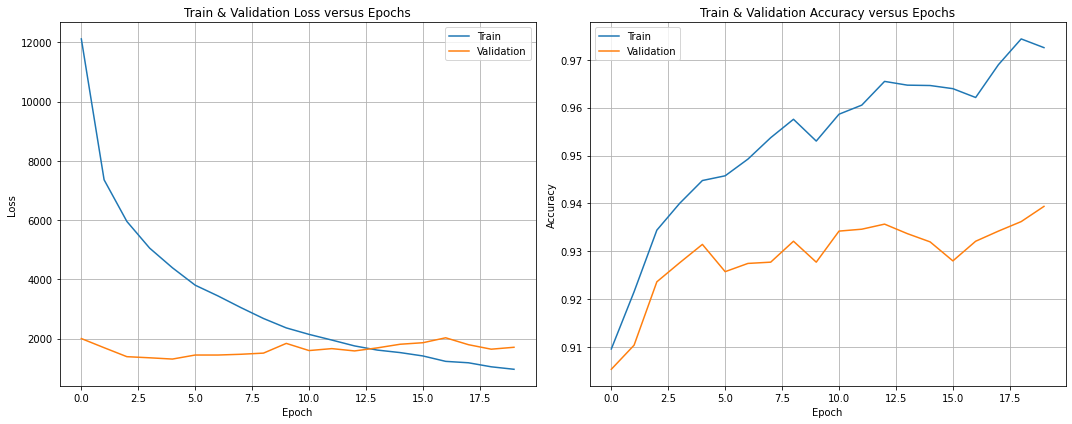

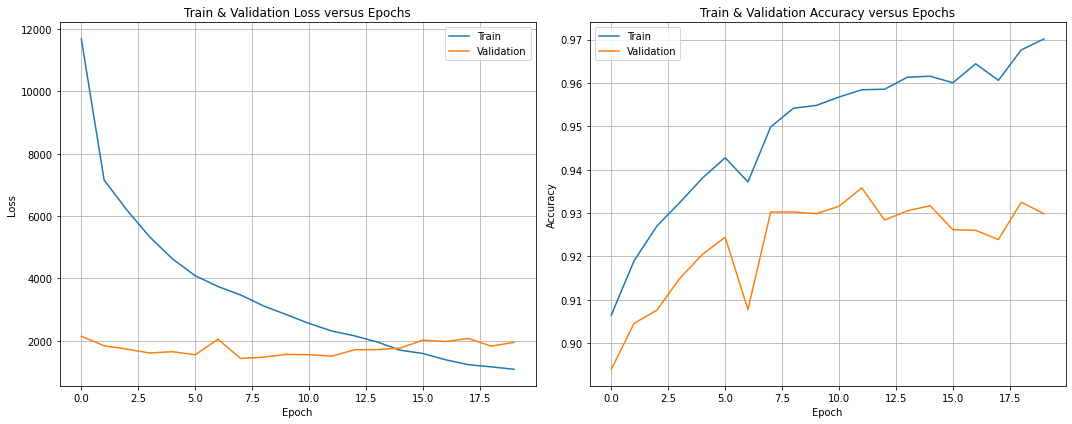

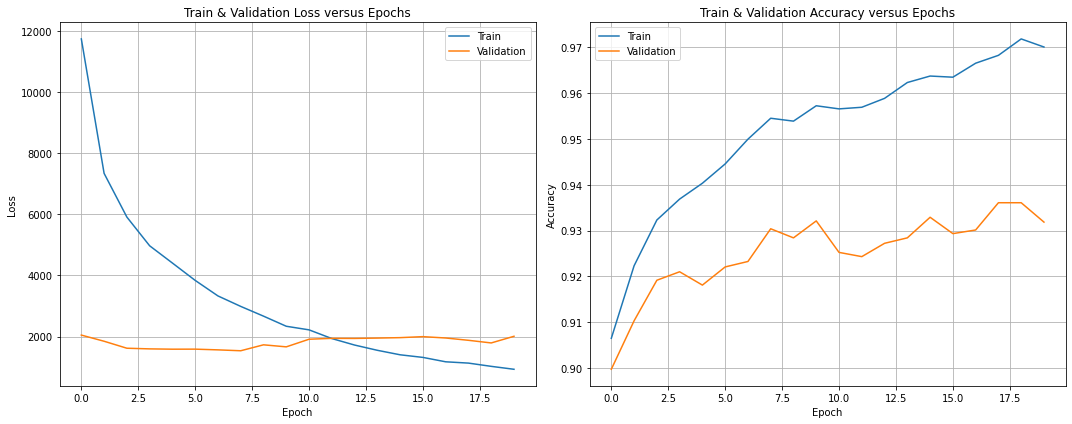

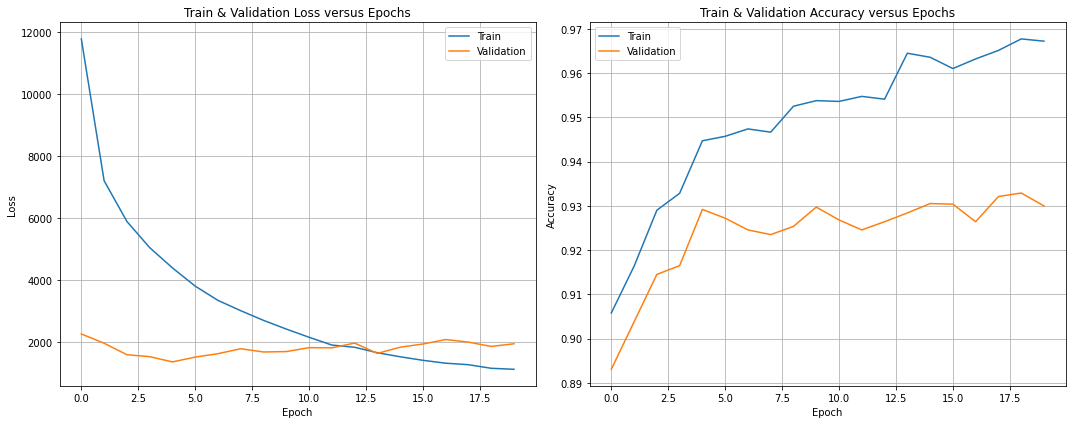

In [0]:
embeddings = {
    'Word2Vec': InputEmbedding(use_word2vec=True, use_pos=False, use_tfidf=False),
    'Word2Vec + POS-Tag': InputEmbedding(use_word2vec=True, use_pos=True, use_tfidf=False),
    'Word2Vec + TFIDF': InputEmbedding(use_word2vec=True, use_pos=False, use_tfidf=True),
    'Word2Vec + POS-Tag + TFIDF': InputEmbedding(use_word2vec=True, use_pos=True, use_tfidf=True)
}

# mount to my drive
from google.colab import drive
drive.mount('/content/drive')


# loop through all embedding combinations and do experiment
input_embedding_evaluation_results = {}
for name, embedding in tqdm(embeddings.items()):
  # log
  expr_name = f'Input Embedding={name} NER=Bi-LSTM CRF Layer=Single Attention=None'
  print('\n\n' + '=' * 100)
  print('Start Experiment:', expr_name)

  # build Bi-LSTM CRF model
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  HIDDEN_DIM = 50
  NUM_LAYER = 1
  model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, embedding_dim, embedding_matrix, HIDDEN_DIM, NUM_LAYER).to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

  # start experiment
  result, loss_train, loss_val, acc_train, acc_val= conduct_one_experiment(model, optimizer, expr_name)
  result['loss_train'] = loss_train
  result['loss_val'] = loss_val
  result['acc_train'] = acc_train
  result['acc_val'] = acc_val
  input_embedding_evaluation_results[name] = result

In [0]:
import pickle

# mount to my drive
from google.colab import drive
drive.mount('/content/drive')

# save results
input_embedding_file_name = 'drive/My Drive/input_embedding_exprs.pkl'
print('Saving to', input_embedding_file_name)
with open(input_embedding_file_name, 'wb') as f:
  pickle.dump(input_embedding_evaluation_results, f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Saving to drive/My Drive/input_embedding_exprs.pkl


#### 5.2.1 Analysis


In [0]:
def multi_draw(loss_train,loss_val,acc_train,acc_val,label,save_path=None):

  
  """Draw train loss and validation loss versus epochs."""
  pl.figure(figsize=(15, 6))
  colour=['red','orange','green','blue']
  epochs = range(20)
  # draw loss
  pl.subplot(1,2, 1)
  for i in range(len(loss_train)):
        pl.plot(epochs, loss_train[i], label=label[i]+' (train)',color=colour[i],linestyle=':')
        pl.plot(epochs, loss_val[i], label=label[i]+' (val)',color=colour[i])
  pl.xlabel('Epoch')
  pl.ylabel('Loss')
  pl.title('Train & Validation Loss versus Epochs')
  pl.legend()
  pl.grid()
  # draw accuracy
  pl.subplot(1,2, 2)
  for i in range(len(loss_train)):
      pl.plot(epochs, acc_train[i],label=label[i]+' (train)',color=colour[i],linestyle=':')
      pl.plot(epochs, acc_val[i],label=label[i]+' (val)',color=colour[i])
  pl.xlabel('Epoch')
  pl.ylabel('Accuracy')
  pl.title('Train & Validation Accuracy versus Epochs')
  pl.grid()
  pl.legend()
  pl.tight_layout()
  if not save_path:
    pl.show()
  else:
    print('Saving to', save_path)
    pl.savefig(save_path)


In [0]:
from collections import defaultdict

ner_tags = ['I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']

def process_results(results, var_name):
  """Process results."""
  # extract results
  df_result = defaultdict(list)
  for _, result in results.items():
    for tag_name in ner_tags:
      df_result[tag_name].append(result[tag_name]['f1-score'])
    df_result['accuracy'].append(result['accuracy'])
    df_result['macro_avg_f1'].append(result['macro avg']['f1-score'])
    df_result['weighted_avg_f1'].append(result['weighted avg']['f1-score'])
  df = pd.DataFrame.from_dict(df_result)
  df[var_name] = list(results.keys())
  df.set_index(var_name, inplace=True)
  return df


def draw_f1_by_neg_tags(df, expr_name):
  """Draw F1 score break down by NER tags for different experiments."""
  df[ner_tags].T.plot(figsize=(8, 6))
  pl.grid()
  pl.xlabel('NER Tags')
  pl.ylabel('F1 Score')
  pl.title('F1 Score break down by NER Tags')
  pl.tight_layout()
  figpath = f'drive/My Drive/comp5046/{expr_name}_f1_breakdown_by_NER.pdf'
  print('Saving to', figpath)
  pl.savefig(figpath)  


def draw_acc_f1(df, expr_name):
  """Draw accuracy and weighted f1 score on validation set."""
  df[['accuracy', 'weighted_avg_f1']].plot(style='o-', figsize=(8, 6))
  pl.grid()
  pl.ylabel('Score')
  pl.title('Accuracy and Weighted Avg F1 on Validation Set')
  pl.tight_layout()
  figpath = f'drive/My Drive/comp5046/{expr_name}_accuracy_f1.pdf'
  print('Saving to', figpath)
  pl.savefig(figpath)

##### 5.2.1.1 F1 Score Break Down by NER Tags

Saving to drive/My Drive/embedding_combo.pdf


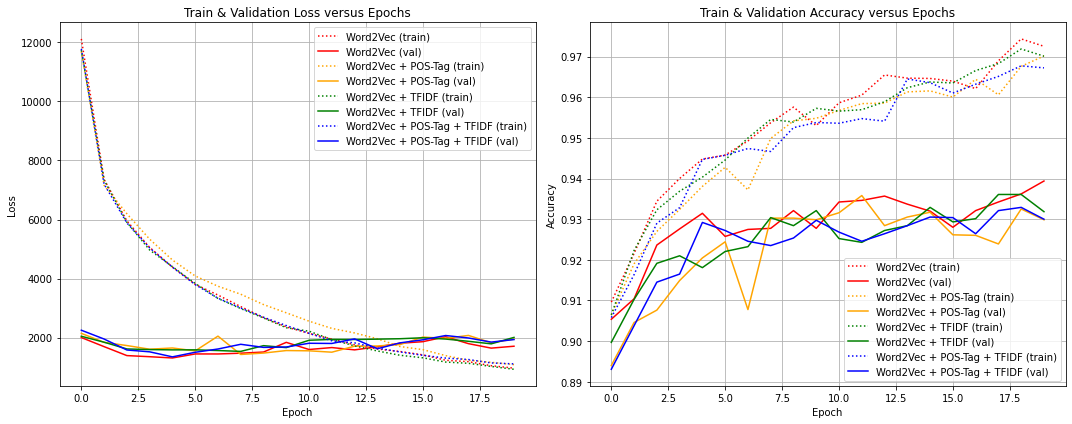

In [0]:
loss_train, loss_val, acc_train, acc_val = [], [], [], []
for res in input_embedding_evaluation_results.values():
  loss_train.append(res['loss_train'])
  loss_val.append(res['loss_val'])
  acc_train.append(res['acc_train'])
  acc_val.append(res['acc_val'])
  
loss_train = np.array(loss_train)
loss_val = np.array(loss_val)
acc_train = np.array(acc_train)
acc_val = np.array(acc_val)

multi_draw(loss_train, loss_val, acc_train, acc_val,
           list(input_embedding_evaluation_results.keys()),
           'drive/My Drive/embedding_combo.pdf')

Saving to drive/My Drive/comp5046/input_embedding_f1_breakdown_by_NER.pdf


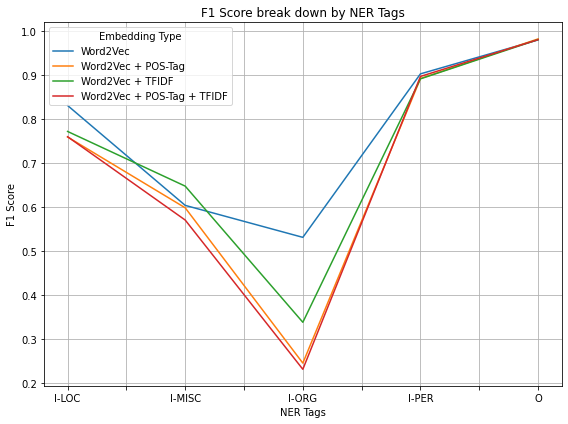

In [0]:
df = process_results(input_embedding_evaluation_results, 'Embedding Type')
draw_f1_by_neg_tags(df, 'input_embedding')

##### 5.2.1.2 Accuracy and Weighted F1 versus Embedding Type

Saving to drive/My Drive/comp5046/input_embedding_accuracy_f1.pdf


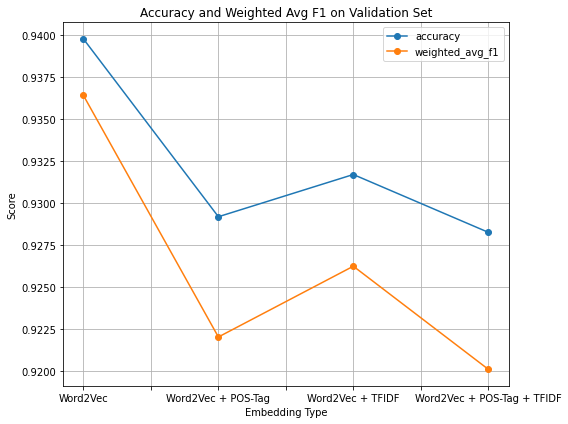

In [0]:
draw_acc_f1(df, 'input_embedding')












### 5.3 Number of Layers in Bi-LSTM CRF Experiments

In this section, we experiment the Bi_LSTM CRF model with different layers:

1. Single Layer
2. Double Layer
3. Tripple Layer

and compare the results of validation.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).




Start Experiment: Input Embedding=Word2Vec + POS-Tag + TFIDF NER=Bi-LSTM CRF Layer=Single Attention=None


Epoch:1, Training loss: 11948.52, train acc: 0.9090, val loss: 2179.13, val acc: 0.8981, time: 120.11s
Epoch:2, Training loss: 7454.75, train acc: 0.9268, val loss: 1716.32, val acc: 0.9205, time: 119.51s
Epoch:3, Training loss: 6002.59, train acc: 0.9307, val loss: 1635.74, val acc: 0.9181, time: 119.63s
Epoch:4, Training loss: 5011.80, train acc: 0.9375, val loss: 1452.61, val acc: 0.9250, time: 120.12s
Epoch:5, Training loss: 4306.66, train acc: 0.9395, val loss: 1550.24, val acc: 0.9209, time: 120.21s
Epoch:6, Training loss: 3767.58, train acc: 0.9442, val loss: 1510.11, val acc: 0.9235, time: 119.99s
Epoch:7, Training loss: 3284.08, train acc: 0.9470, val loss: 1666.90, val acc: 0.9206, time: 120.10s
Epoch:8, Training loss: 2885.73, train acc: 0.9503, val loss: 1540.51, val acc: 0.9170, time: 120.37s
Epoch:9, Training loss: 2638.68, train acc: 0.9536, val loss: 1545.77, val acc: 0.9217, time: 121.26s
Epoch:10, Training loss: 2374.37, train acc: 0.9529, val loss: 1662.67, val acc: 

Epoch:1, Training loss: 14326.30, train acc: 0.8984, val loss: 2123.33, val acc: 0.8957, time: 148.32s
Epoch:2, Training loss: 7525.56, train acc: 0.9239, val loss: 1637.86, val acc: 0.9190, time: 147.85s
Epoch:3, Training loss: 6033.77, train acc: 0.9328, val loss: 1583.20, val acc: 0.9251, time: 146.84s
Epoch:4, Training loss: 5108.95, train acc: 0.9332, val loss: 1637.44, val acc: 0.9185, time: 148.22s
Epoch:5, Training loss: 4457.08, train acc: 0.9420, val loss: 1531.07, val acc: 0.9272, time: 149.74s
Epoch:6, Training loss: 3869.25, train acc: 0.9477, val loss: 1490.04, val acc: 0.9264, time: 149.99s
Epoch:7, Training loss: 3422.53, train acc: 0.9499, val loss: 1555.47, val acc: 0.9272, time: 150.28s
Epoch:8, Training loss: 3123.47, train acc: 0.9501, val loss: 1646.22, val acc: 0.9248, time: 148.32s
Epoch:9, Training loss: 2780.06, train acc: 0.9548, val loss: 1569.04, val acc: 0.9307, time: 148.51s
Epoch:10, Training loss: 2465.60, train acc: 0.9536, val loss: 1721.52, val acc: 

Epoch:1, Training loss: 18097.76, train acc: 0.8770, val loss: 2677.57, val acc: 0.8642, time: 177.46s
Epoch:2, Training loss: 9095.22, train acc: 0.9052, val loss: 2057.82, val acc: 0.8997, time: 178.09s
Epoch:3, Training loss: 7160.78, train acc: 0.9227, val loss: 1732.00, val acc: 0.9181, time: 177.12s
Epoch:4, Training loss: 6029.51, train acc: 0.9329, val loss: 1637.76, val acc: 0.9234, time: 178.15s
Epoch:5, Training loss: 5211.23, train acc: 0.9369, val loss: 1486.53, val acc: 0.9267, time: 178.21s
Epoch:6, Training loss: 4657.31, train acc: 0.9388, val loss: 1559.39, val acc: 0.9226, time: 179.32s
Epoch:7, Training loss: 4167.30, train acc: 0.9431, val loss: 1467.64, val acc: 0.9246, time: 181.30s
Epoch:8, Training loss: 3752.74, train acc: 0.9462, val loss: 1577.55, val acc: 0.9236, time: 180.92s
Epoch:9, Training loss: 3335.32, train acc: 0.9542, val loss: 1412.87, val acc: 0.9338, time: 178.82s
Epoch:10, Training loss: 3045.48, train acc: 0.9555, val loss: 1405.34, val acc: 

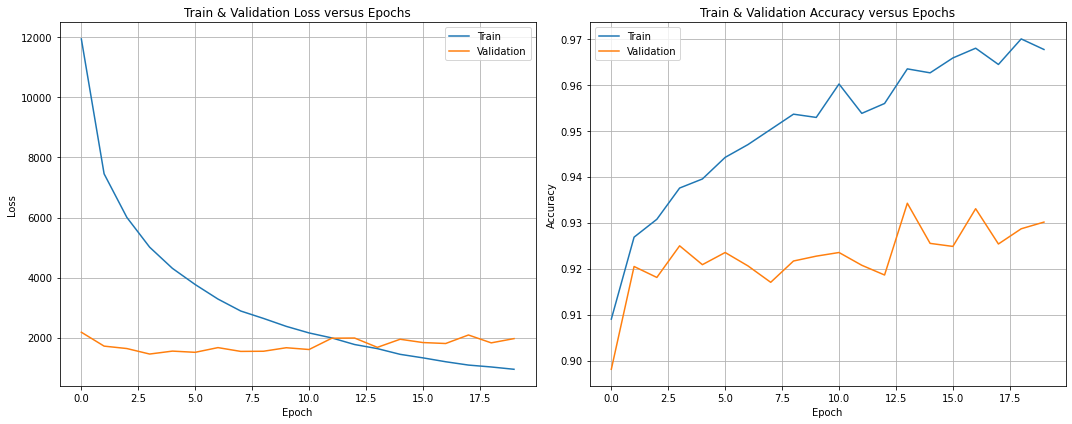

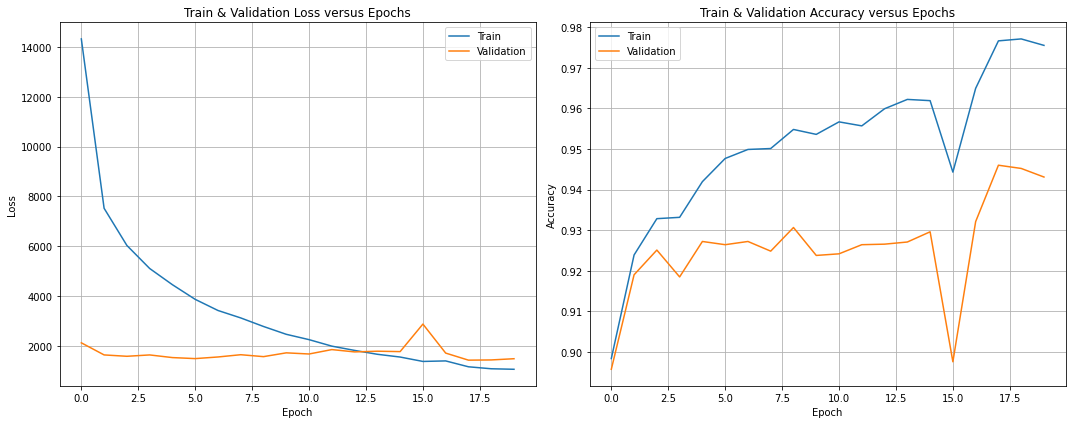

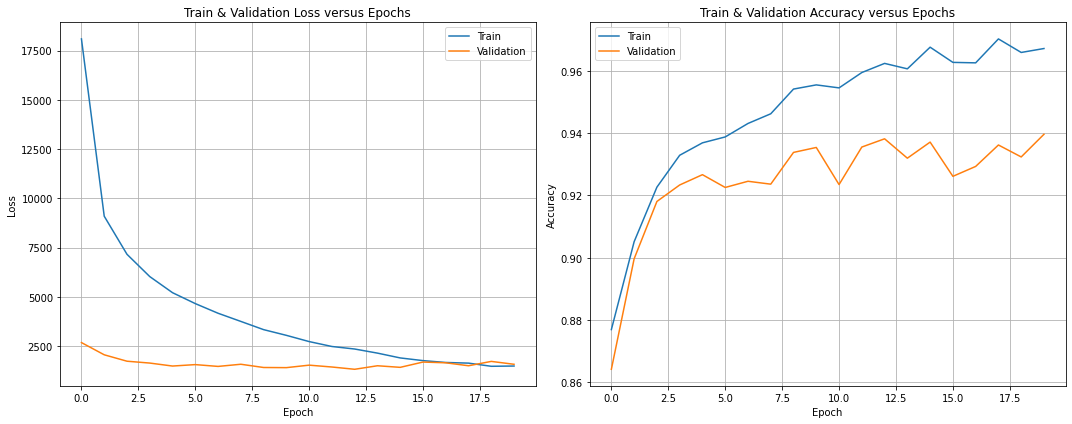

In [0]:
# mount to my drive
from google.colab import drive
drive.mount('/content/drive')

# create embedding
embedding = InputEmbedding(use_word2vec=True, use_pos=True, use_tfidf=True)

layers = {
    'Single': 1,
    'Double': 2,
    'Tripple': 3
}

HIDDEN_DIM = 50
num_layers_evaluation_results = {}

# loop through all possible number of layers and do experiment
for name, num_layer in tqdm(layers.items()):
  # log
  expr_name = f'Input Embedding=Word2Vec + POS-Tag + TFIDF NER=Bi-LSTM CRF Layer={name} Attention=None'
  print('\n\n' + '=' * 100)
  print('Start Experiment:', expr_name)

  # build Bi-LSTM CRF model
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  HIDDEN_DIM = 50
  model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, embedding_dim, embedding_matrix, HIDDEN_DIM, num_layer).to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

  # start experiment
  result, loss_train, loss_val, acc_train, acc_val= conduct_one_experiment(model, optimizer, expr_name)
  result['loss_train'] = loss_train
  result['loss_val'] = loss_val
  result['acc_train'] = acc_train
  result['acc_val'] = acc_val
  num_layers_evaluation_results[name] = result


import pickle

# mount to my drive
from google.colab import drive
drive.mount('/content/drive')
  
# save results
num_layers_file_name = 'drive/My Drive/num_layers_exprs.pkl'
print('Saving to', num_layers_file_name)
with open(num_layers_file_name, 'wb') as f:
  pickle.dump(num_layers_evaluation_results, f)

#### 5.3.1 Analysis

Saving to drive/My Drive/layer_combo.pdf


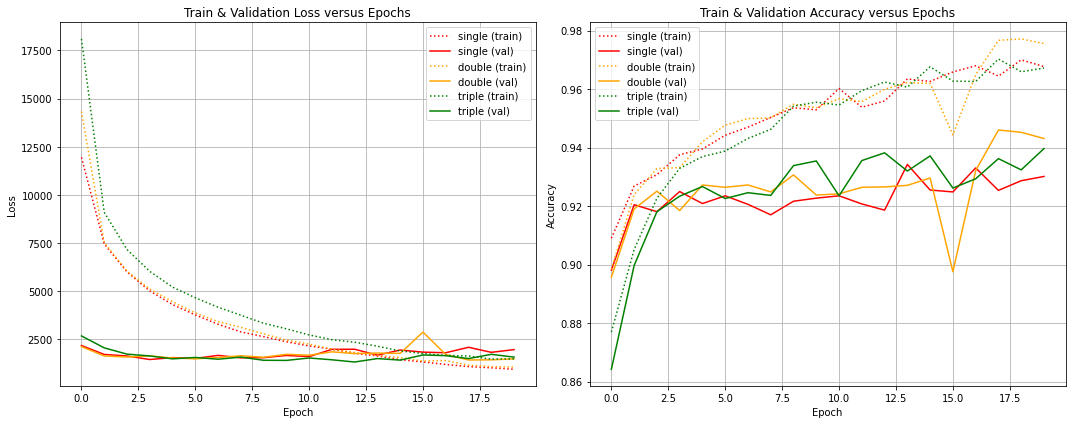

In [0]:
loss_train, loss_val, acc_train, acc_val = [], [], [], []
for res in num_layers_evaluation_results.values():
  loss_train.append(res['loss_train'])
  loss_val.append(res['loss_val'])
  acc_train.append(res['acc_train'])
  acc_val.append(res['acc_val'])
  
loss_train = np.array(loss_train)
loss_val = np.array(loss_val)
acc_train = np.array(acc_train)
acc_val = np.array(acc_val)

multi_draw(loss_train,loss_val,acc_train,acc_val,['single','double','triple'],
           'drive/My Drive/layer_combo.pdf')

##### 5.3.1.1 F1 Score Break Down by NER Tags

Saving to drive/My Drive/comp5046/num_layers_f1_breakdown_by_NER.pdf


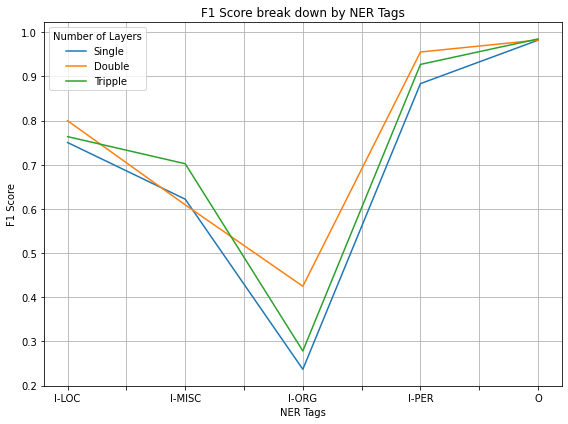

In [0]:
df = process_results(num_layers_evaluation_results, 'Number of Layers')
draw_f1_by_neg_tags(df, 'num_layers')

##### 5.3.1.2 Accuracy and Weighted F1 versus Number of Layers

Saving to drive/My Drive/comp5046/num_layers_accuracy_f1.pdf


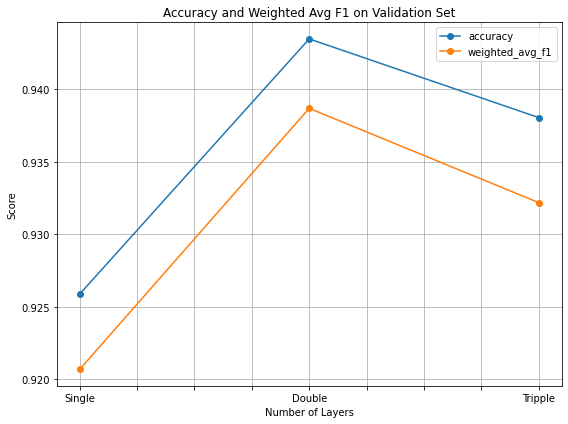

In [0]:
draw_acc_f1(df, 'num_layers')

### 5.4 Ablation Study - Differernt Attention Strategy

#### 5.4.1 ELMo Bi-LSTM without Attention

In [0]:
import json

sess = tf.Session()
K.set_session(sess)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

# ELMO Bi-LSTM without Attention
elmo_no_attn = ELMO_BiLSTM(max_len, n_tags, use_attention=False)

filename_template_model = 'drive/My Drive/ELMO_BiLSTM_{}.h5'
filename_template_log = 'drive/My Drive/log_ELMO_BiLSTM_{}.json'

nepochs = 20

att_no = elmo_no_attn.train(X_tr, y_tr, X_val, y_val, nepochs, batch_size)

# evaluate on validation set
print('=' * 100)
print('ELMO Bi-LSTM without Attention')
print(cal_val_f1(elmo_no_attn.model, validation_data,X_val,val_output_index))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 124)               0         
_________________________________________________________________
lambda_5 (Lambda)            (None, None, 1024)        0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, None, 1024)        6295552   
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 7)           7175      
Total params: 6,302,727
Trainable params: 6,302,727
Non-trainable params: 0
_________________________________________________________________
None
Train on 3000 samples, validate on 700 samples
Epoch 1/20
3000/3000 [==============================] - 105s 35ms/step - loss: 0.0466 - accuracy: 0.9848 - val_loss: 0.0164 - val_accuracy: 0.9938
Epoch 2/20
3000/3000 [==========================


              precision    recall  f1-score   support

           2     0.9870    0.9952    0.9911      5790
           3     0.8726    0.7930    0.8309       285
           4     0.8698    0.7861    0.8258       187
           5     0.9716    0.9771    0.9744       875
           6     0.9463    0.9260    0.9361       419

    accuracy                         0.9764      7556
   macro avg     0.9295    0.8955    0.9116      7556
weighted avg     0.9757    0.9764    0.9759      7556



In [0]:
# save model
filename_model = filename_template_model.format('No_ATTN')
filename_log = filename_template_log.format('No_ATTN')

print('Saving to', filename_model)
elmo_no_attn.model.save(filename_model)

# save logs
print('Saving to', filename_log)
with open(filename_log, 'w') as f:
  json.dump(str(att_no.history), f)

Saving to drive/My Drive/ELMO_BiLSTM_No_ATTN.h5
Saving to drive/My Drive/log_ELMO_BiLSTM_No_ATTN.json


#### 5.4.2 ELMo Bi-LSTM with Attention Add

In [0]:
# ELMO Bi-LSTM with Attention (Type=Add)
elmo_attn_add = ELMO_BiLSTM(max_len, n_tags, use_attention=True,
                           attention_type=SeqSelfAttention.ATTENTION_TYPE_ADD)

att_add = elmo_attn_add.train(X_tr, y_tr, X_val, y_val, nepochs, batch_size)

# evaluate on validation set
print('=' * 100)
print('ELMO Bi-LSTM with Attention Add')

print(cal_val_f1(elmo_attn_add.model, validation_data,X_val,val_output_index))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 124)               0         
_________________________________________________________________
lambda_4 (Lambda)            (None, None, 1024)        0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, None, 1024)        6295552   
_________________________________________________________________
seq_self_attention_3 (SeqSel (None, None, 1024)        65601     
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 7)           7175      
Total params: 6,368,328
Trainable params: 6,368,328
Non-trainable params: 0
_________________________________________________________________
None
Train on 3000 samples, validate on 700 samples
Epoch 1/20
3000/3000 [==============================] - 106s 35


              precision    recall  f1-score   support

           2     0.9801    0.9938    0.9869      5790
           3     0.8937    0.6491    0.7520       285
           4     0.8819    0.6791    0.7674       187
           5     0.9495    0.9669    0.9581       875
           6     0.8758    0.9260    0.9002       419

    accuracy                         0.9661      7556
   macro avg     0.9162    0.8430    0.8729      7556
weighted avg     0.9651    0.9661    0.9645      7556



In [0]:
# ELMO Bi-LSTM with Attention (Type=Add)
elmo_attn_add = ELMO_BiLSTM(max_len, n_tags, use_attention=True,
                           attention_type=SeqSelfAttention.ATTENTION_TYPE_ADD)

att_add = elmo_attn_add.train(X_tr, y_tr, X_val, y_val, nepochs, batch_size)

# evaluate on validation set
print('=' * 100)
print('ELMO Bi-LSTM with Attention Add')

print(cal_val_f1(elmo_attn_add.model, validation_data,X_val,val_output_index))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 124)               0         
_________________________________________________________________
lambda_2 (Lambda)            (None, None, 1024)        0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 1024)        6295552   
_________________________________________________________________
seq_self_attention_1 (SeqSel (None, None, 1024)        65601     
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 7)           7175      
Total params: 6,368,328
Trainable params: 6,368,328
Non-trainable params: 0
_________________________________________________________________
None
Train on 3000 samples, validate on 700 samples
Epoch 1/20
3000/3000 [==============================] - 104s 35


              precision    recall  f1-score   support

           2     0.9851    0.9905    0.9878      5790
           3     0.8484    0.7263    0.7826       285
           4     0.8049    0.7059    0.7521       187
           5     0.9441    0.9851    0.9642       875
           6     0.9177    0.9045    0.9111       419

    accuracy                         0.9681      7556
   macro avg     0.9000    0.8625    0.8796      7556
weighted avg     0.9670    0.9681    0.9672      7556



In [0]:
# save model
filename_model = filename_template_model.format('ATTN_ADD')
filename_log = filename_template_log.format('ATTN_ADD')

print('Saving to', filename_model)
elmo_attn_add.model.save(filename_model)

# save logs
print('Saving to', filename_log)
with open(filename_log, 'w') as f:
  json.dump(str(att_add.history), f)


Saving to drive/My Drive/ELMO_BiLSTM_ATTN_ADD.h5
Saving to drive/My Drive/log_ELMO_BiLSTM_ATTN_ADD.txt


#### 5.4.3 ELMo Bi-LSTM with Attention Mul

In [0]:
# ELMO Bi-LSTM with Attention (Type=Add)
elmo_att_mul = ELMO_BiLSTM(max_len, n_tags, use_attention=True,
                           attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL)

att_mul = elmo_att_mul.train(X_tr, y_tr, X_val, y_val, nepochs, batch_size)

# evaluate on validation set
print('=' * 100)
print('ELMO Bi-LSTM with Attention MUL')
print(cal_val_f1(elmo_att_mul.model, validation_data,X_val,val_output_index))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 124)               0         
_________________________________________________________________
lambda_3 (Lambda)            (None, None, 1024)        0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, None, 1024)        6295552   
_________________________________________________________________
seq_self_attention_2 (SeqSel (None, None, 1024)        1048577   
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 7)           7175      
Total params: 7,351,304
Trainable params: 7,351,304
Non-trainable params: 0
_________________________________________________________________
None
Train on 3000 samples, validate on 700 samples
Epoch 1/20
3000/3000 [==============================] - 106s 35


              precision    recall  f1-score   support

           2     0.9819    0.9948    0.9883      5790
           3     0.8878    0.6105    0.7235       285
           4     0.8293    0.7273    0.7749       187
           5     0.9615    0.9714    0.9665       875
           6     0.8744    0.9308    0.9017       419

    accuracy                         0.9674      7556
   macro avg     0.9070    0.8470    0.8710      7556
weighted avg     0.9663    0.9674    0.9657      7556



In [0]:
# save model
filename_model = filename_template_model.format('ATTN_MUL')
filename_log = filename_template_log.format('ATTN_MUL')

print('Saving to', filename_model)
elmo_att_mul.model.save(filename_model)

# save logs
print('Saving to', filename_log)
with open(filename_log, 'w') as f:
  json.dump(str(att_mul.history), f)


Saving to drive/My Drive/ELMO_BiLSTM_ATTN_MUL.h5
Saving to drive/My Drive/log_ELMO_BiLSTM_ATTN_MUL.txt


#### 5.4.4 Analysis

Saving to drive/My Drive/attention_combo.pdf


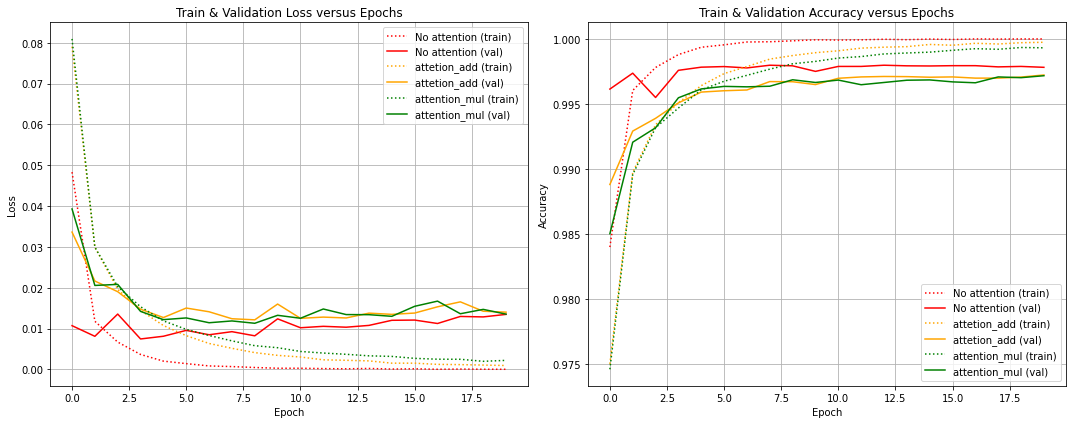

In [0]:
loss_train=np.reshape(att_no.history['loss']+att_add.history['loss']+att_mul.history['loss'],(-1,20))
loss_val=np.reshape(att_no.history['val_loss']+att_add.history['val_loss']+att_mul.history['val_loss'],(-1,20))
acc_train=np.reshape(att_no.history['accuracy']+att_add.history['accuracy']+att_mul.history['accuracy'],(-1,20))
acc_val=np.reshape(att_no.history['val_accuracy']+att_add.history['val_accuracy']+att_mul.history['val_accuracy'],(-1,20))

multi_draw(loss_train,loss_val,acc_train,acc_val,['No attention','attetion_add','attention_mul'],
           'drive/My Drive/attention_combo.pdf')

### 5.5 Numbers of Epochs and F1 Score Experiments

#### 5.5.1 Train model

In [0]:
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report

rec_pred_val=[]
rec_true_val=[]

# define ELMO Bi-LSTM model
elmo_no_attn = ELMO_BiLSTM(max_len, n_tags, use_attention=False)

for j in range(40):
  elmo_no_attn.model.fit(np.array(X_tr+X_val), 
                         np.concatenate((y_tr,y_val),axis=0),
                         batch_size=batch_size, 
                         epochs=1,
                         validation_split=0.189189, 
                         verbose=1)
  pred_val = []
  for i in tqdm(range(ntimes)):
    start = (i * batch_size)
    end = (i + 1) * batch_size
    val_batch = np.array(X_val[start: end])
    true_val_batch = validation_data[start: end]
    prediction = elmo_no_attn.model.predict(val_batch)
    prediction = np.argmax(prediction, axis=-1)
    pred_val += get_nonpad_prediction(true_val_batch, prediction)

  flat_pred_val = []
  flat_true_val = []
  for i, (p_val, t_val) in enumerate(zip(pred_val, val_output_index)):
    assert(len(p_val) == len(t_val)), f'{p_val}, {t_val}'
    flat_pred_val += list(p_val)
    flat_true_val += t_val

  rec_pred_val.append(flat_pred_val)
  rec_true_val.append(flat_true_val)
  

3700
Train on 3000 samples, validate on 700 samples
Epoch 1/1
3000/3000 [==============================] - 100s 33ms/step - loss: 0.0479 - accuracy: 0.9848 - val_loss: 0.0101 - val_accuracy: 0.9964


(20, 124)

3684
Saving to drive/My Drive/elmo_epoch1.csv
Train on 3000 samples, validate on 700 samples
Epoch 1/1
3000/3000 [==============================] - 98s 33ms/step - loss: 0.0114 - accuracy: 0.9962 - val_loss: 0.0084 - val_accuracy: 0.9971


(20, 124)

3684
Saving to drive/My Drive/elmo_epoch2.csv
Train on 3000 samples, validate on 700 samples
Epoch 1/1
3000/3000 [==============================] - 98s 33ms/step - loss: 0.0060 - accuracy: 0.9980 - val_loss: 0.0076 - val_accuracy: 0.9975


(20, 124)

3684
Saving to drive/My Drive/elmo_epoch3.csv
Train on 3000 samples, validate on 700 samples
Epoch 1/1
3000/3000 [==============================] - 98s 33ms/step - loss: 0.0030 - accuracy: 0.9990 - val_loss: 0.0077 - val_accuracy: 0.9976


(20, 124)

3684
Saving to drive/My Drive/elmo_epoch4.csv
Train on 3000 samples, validate on 700 samples
Epoch 1/1
3000/3000 [==============================] - 98s 33ms/step - loss: 0.0017 - accuracy: 0.9995 - val_loss: 0.0085 - val_accuracy: 0.9977


(20, 124)

3684
Saving to drive/My Drive/elmo_epoch5.csv
Train on 3000 samples, validate on 700 samples
Epoch 1/1
3000/3000 [==============================] - 97s 32ms/step - loss: 8.9994e-04 - accuracy: 0.9997 - val_loss: 0.0094 - val_accuracy: 0.9976


(20, 124)

3684
Saving to drive/My Drive/elmo_epoch6.csv
Train on 3000 samples, validate on 700 samples
Epoch 1/1
3000/3000 [==============================] - 97s 32ms/step - loss: 6.5605e-04 - accuracy: 0.9998 - val_loss: 0.0087 - val_accuracy: 0.9979


(20, 124)

3684
Saving to drive/My Drive/elmo_epoch7.csv
Train on 3000 samples, validate on 700 samples
Epoch 1/1
3000/3000 [==============================] - 97s 32ms/step - loss: 4.2818e-04 - accuracy: 0.9999 - val_loss: 0.0116 - val_accuracy: 0.9976


(20, 124)

3684
Saving to drive/My Drive/elmo_epoch8.csv
Train on 3000 samples, validate on 700 samples
Epoch 1/1
3000/3000 [==============================] - 97s 32ms/step - loss: 2.9982e-04 - accuracy: 0.9999 - val_loss: 0.0093 - val_accuracy: 0.9978


(20, 124)

3684
Saving to drive/My Drive/elmo_epoch9.csv
Train on 3000 samples, validate on 700 samples
Epoch 1/1
3000/3000 [==============================] - 97s 32ms/step - loss: 3.1919e-04 - accuracy: 0.9999 - val_loss: 0.0112 - val_accuracy: 0.9978


(20, 124)

3684
Saving to drive/My Drive/elmo_epoch10.csv
Train on 3000 samples, validate on 700 samples
Epoch 1/1
3000/3000 [==============================] - 97s 32ms/step - loss: 1.5050e-04 - accuracy: 1.0000 - val_loss: 0.0107 - val_accuracy: 0.9978


(20, 124)

3684
Saving to drive/My Drive/elmo_epoch11.csv
Train on 3000 samples, validate on 700 samples
Epoch 1/1
3000/3000 [==============================] - 97s 32ms/step - loss: 1.5681e-04 - accuracy: 0.9999 - val_loss: 0.0103 - val_accuracy: 0.9979


(20, 124)

3684
Saving to drive/My Drive/elmo_epoch12.csv
Train on 3000 samples, validate on 700 samples
Epoch 1/1
3000/3000 [==============================] - 97s 32ms/step - loss: 9.6024e-05 - accuracy: 1.0000 - val_loss: 0.0118 - val_accuracy: 0.9978


(20, 124)

3684
Saving to drive/My Drive/elmo_epoch13.csv
Train on 3000 samples, validate on 700 samples
Epoch 1/1
3000/3000 [==============================] - 98s 33ms/step - loss: 3.1314e-05 - accuracy: 1.0000 - val_loss: 0.0116 - val_accuracy: 0.9979


(20, 124)

3684
Saving to drive/My Drive/elmo_epoch14.csv
Train on 3000 samples, validate on 700 samples
Epoch 1/1
3000/3000 [==============================] - 97s 32ms/step - loss: 8.6475e-05 - accuracy: 1.0000 - val_loss: 0.0120 - val_accuracy: 0.9979


(20, 124)

3684
Saving to drive/My Drive/elmo_epoch15.csv
Train on 3000 samples, validate on 700 samples
Epoch 1/1
3000/3000 [==============================] - 97s 32ms/step - loss: 4.9545e-05 - accuracy: 1.0000 - val_loss: 0.0117 - val_accuracy: 0.9980


(20, 124)

3684
Saving to drive/My Drive/elmo_epoch16.csv
Train on 3000 samples, validate on 700 samples
Epoch 1/1
3000/3000 [==============================] - 97s 32ms/step - loss: 1.7748e-05 - accuracy: 1.0000 - val_loss: 0.0138 - val_accuracy: 0.9978


(20, 124)

3684
Saving to drive/My Drive/elmo_epoch17.csv
Train on 3000 samples, validate on 700 samples
Epoch 1/1
3000/3000 [==============================] - 97s 32ms/step - loss: 4.0189e-06 - accuracy: 1.0000 - val_loss: 0.0147 - val_accuracy: 0.9979


(20, 124)

3684
Saving to drive/My Drive/elmo_epoch18.csv
Train on 3000 samples, validate on 700 samples
Epoch 1/1
3000/3000 [==============================] - 97s 32ms/step - loss: 1.0277e-05 - accuracy: 1.0000 - val_loss: 0.0133 - val_accuracy: 0.9980


(20, 124)

3684
Saving to drive/My Drive/elmo_epoch19.csv
Train on 3000 samples, validate on 700 samples
Epoch 1/1
3000/3000 [==============================] - 97s 32ms/step - loss: 6.8271e-05 - accuracy: 1.0000 - val_loss: 0.0133 - val_accuracy: 0.9978


(20, 124)

3684
Saving to drive/My Drive/elmo_epoch20.csv
Train on 3000 samples, validate on 700 samples
Epoch 1/1
3000/3000 [==============================] - 97s 32ms/step - loss: 3.7293e-06 - accuracy: 1.0000 - val_loss: 0.0131 - val_accuracy: 0.9980


(20, 124)

3684
Saving to drive/My Drive/elmo_epoch21.csv
Train on 3000 samples, validate on 700 samples
Epoch 1/1
3000/3000 [==============================] - 97s 32ms/step - loss: 1.6868e-06 - accuracy: 1.0000 - val_loss: 0.0139 - val_accuracy: 0.9979


(20, 124)

3684
Saving to drive/My Drive/elmo_epoch22.csv
Train on 3000 samples, validate on 700 samples
Epoch 1/1
3000/3000 [==============================] - 97s 32ms/step - loss: 8.9609e-07 - accuracy: 1.0000 - val_loss: 0.0148 - val_accuracy: 0.9979


(20, 124)

3684
Saving to drive/My Drive/elmo_epoch23.csv
Train on 3000 samples, validate on 700 samples
Epoch 1/1
3000/3000 [==============================] - 97s 32ms/step - loss: 7.8735e-07 - accuracy: 1.0000 - val_loss: 0.0147 - val_accuracy: 0.9979


(20, 124)

3684
Saving to drive/My Drive/elmo_epoch24.csv
Train on 3000 samples, validate on 700 samples
Epoch 1/1
3000/3000 [==============================] - 97s 32ms/step - loss: 8.2091e-07 - accuracy: 1.0000 - val_loss: 0.0152 - val_accuracy: 0.9979


(20, 124)

3684
Saving to drive/My Drive/elmo_epoch25.csv
Train on 3000 samples, validate on 700 samples
Epoch 1/1
3000/3000 [==============================] - 98s 33ms/step - loss: 2.2137e-05 - accuracy: 1.0000 - val_loss: 0.0150 - val_accuracy: 0.9978


(20, 124)

3684
Saving to drive/My Drive/elmo_epoch26.csv
Train on 3000 samples, validate on 700 samples
Epoch 1/1
3000/3000 [==============================] - 97s 32ms/step - loss: 1.3659e-06 - accuracy: 1.0000 - val_loss: 0.0153 - val_accuracy: 0.9979


(20, 124)

3684
Saving to drive/My Drive/elmo_epoch27.csv
Train on 3000 samples, validate on 700 samples
Epoch 1/1
3000/3000 [==============================] - 98s 33ms/step - loss: 8.1018e-07 - accuracy: 1.0000 - val_loss: 0.0149 - val_accuracy: 0.9979


(20, 124)

3684
Saving to drive/My Drive/elmo_epoch28.csv
Train on 3000 samples, validate on 700 samples
Epoch 1/1
3000/3000 [==============================] - 97s 32ms/step - loss: 8.0950e-07 - accuracy: 1.0000 - val_loss: 0.0153 - val_accuracy: 0.9980


(20, 124)

3684
Saving to drive/My Drive/elmo_epoch29.csv
Train on 3000 samples, validate on 700 samples
Epoch 1/1
3000/3000 [==============================] - 98s 33ms/step - loss: 7.6394e-07 - accuracy: 1.0000 - val_loss: 0.0150 - val_accuracy: 0.9980


(20, 124)

3684
Saving to drive/My Drive/elmo_epoch30.csv
Train on 3000 samples, validate on 700 samples
Epoch 1/1
3000/3000 [==============================] - 98s 33ms/step - loss: 7.4890e-07 - accuracy: 1.0000 - val_loss: 0.0151 - val_accuracy: 0.9979


(20, 124)

3684
Saving to drive/My Drive/elmo_epoch31.csv
Train on 3000 samples, validate on 700 samples
Epoch 1/1
3000/3000 [==============================] - 98s 33ms/step - loss: 7.3731e-07 - accuracy: 1.0000 - val_loss: 0.0153 - val_accuracy: 0.9979


(20, 124)

3684
Saving to drive/My Drive/elmo_epoch32.csv
Train on 3000 samples, validate on 700 samples
Epoch 1/1
3000/3000 [==============================] - 98s 33ms/step - loss: 7.3448e-07 - accuracy: 1.0000 - val_loss: 0.0153 - val_accuracy: 0.9979


(20, 124)

3684
Saving to drive/My Drive/elmo_epoch33.csv
Train on 3000 samples, validate on 700 samples
Epoch 1/1
3000/3000 [==============================] - 97s 32ms/step - loss: 7.3576e-07 - accuracy: 1.0000 - val_loss: 0.0154 - val_accuracy: 0.9979


(20, 124)

3684
Saving to drive/My Drive/elmo_epoch34.csv
Train on 3000 samples, validate on 700 samples
Epoch 1/1
3000/3000 [==============================] - 98s 33ms/step - loss: 7.2978e-07 - accuracy: 1.0000 - val_loss: 0.0155 - val_accuracy: 0.9979


(20, 124)

3684
Saving to drive/My Drive/elmo_epoch35.csv
Train on 3000 samples, validate on 700 samples
Epoch 1/1
3000/3000 [==============================] - 98s 33ms/step - loss: 7.2769e-07 - accuracy: 1.0000 - val_loss: 0.0154 - val_accuracy: 0.9979


(20, 124)

3684
Saving to drive/My Drive/elmo_epoch36.csv
Train on 3000 samples, validate on 700 samples
Epoch 1/1
3000/3000 [==============================] - 98s 33ms/step - loss: 7.2716e-07 - accuracy: 1.0000 - val_loss: 0.0155 - val_accuracy: 0.9979


(20, 124)

3684
Saving to drive/My Drive/elmo_epoch37.csv
Train on 3000 samples, validate on 700 samples
Epoch 1/1
3000/3000 [==============================] - 97s 32ms/step - loss: 7.3128e-07 - accuracy: 1.0000 - val_loss: 0.0157 - val_accuracy: 0.9979


(20, 124)

3684
Saving to drive/My Drive/elmo_epoch38.csv
Train on 3000 samples, validate on 700 samples
Epoch 1/1
3000/3000 [==============================] - 97s 32ms/step - loss: 7.4077e-07 - accuracy: 1.0000 - val_loss: 0.0155 - val_accuracy: 0.9980


(20, 124)

3684
Saving to drive/My Drive/elmo_epoch39.csv
Train on 3000 samples, validate on 700 samples
Epoch 1/1
3000/3000 [==============================] - 97s 32ms/step - loss: 7.2615e-07 - accuracy: 1.0000 - val_loss: 0.0155 - val_accuracy: 0.9979


(20, 124)

3684
Saving to drive/My Drive/elmo_epoch40.csv


#### 5.5.2 F1 Score for Sub-Classes and test set

In [0]:
# save list to csv
pred_val_csv=pd.DataFrame(data=rec_pred_val)
pred_val_csv.to_csv('drive/My Drive/pred_val.csv', index=False)

true_val_csv=pd.DataFrame(data=rec_true_val)
true_val_csv.to_csv('drive/My Drive/true_val.csv', index=False)

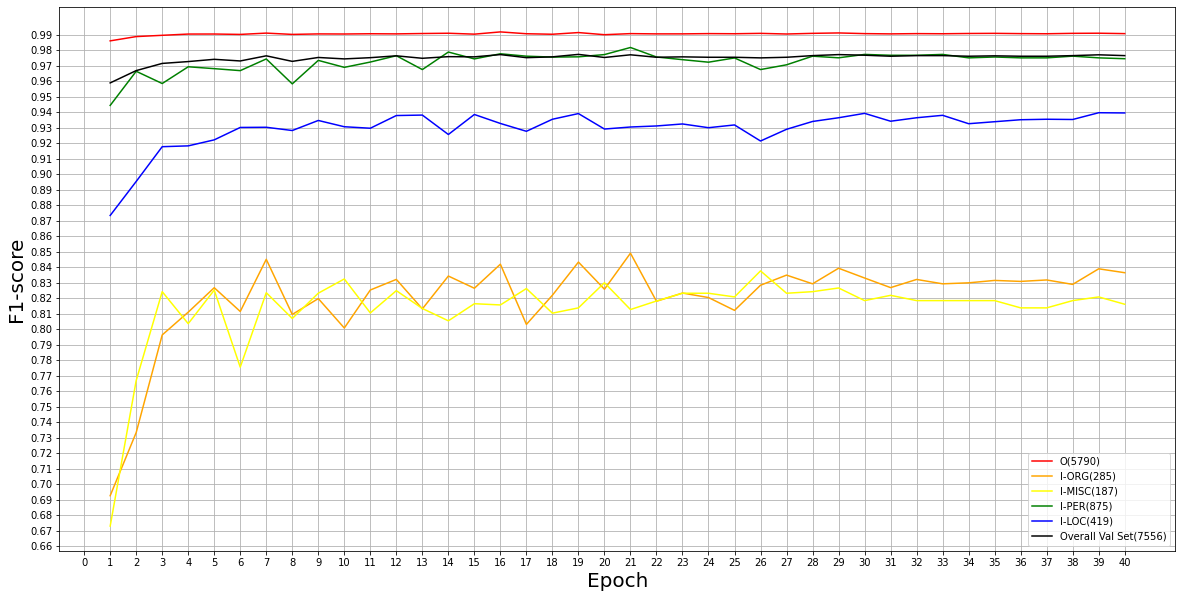

In [0]:
# draw graph
O_f1=[]
ORG_f1=[]
MISC_f1=[]
PER_f1=[]
LOC_f1=[]
acc_f1=[]

for i in range(len(rec_pred_val)):
  f1_dict=classification_report(rec_true_val[i],rec_pred_val[i],output_dict=True)
  O_f1.append(f1_dict['2']['f1-score'])
  ORG_f1.append(f1_dict['3']['f1-score'])
  MISC_f1.append(f1_dict['4']['f1-score'])
  PER_f1.append(f1_dict['5']['f1-score'])
  LOC_f1.append(f1_dict['6']['f1-score'])
  acc_f1.append(f1_dict['accuracy'])

f1=[]
f1.append(O_f1)
f1.append(ORG_f1)
f1.append(MISC_f1)
f1.append(PER_f1)
f1.append(LOC_f1)
f1.append(acc_f1)

colour=['red','orange','yellow','green','blue','black']
NER_lable=['O(%d)'%(f1_dict['2']['support']),'I-ORG(%d)'%f1_dict['3']['support'],
           'I-MISC(%d)'%f1_dict['4']['support'],'I-PER(%d)'%f1_dict['5']['support'],
           'I-LOC(%d)'%f1_dict['6']['support'],'Overall Val Set(%d)'%f1_dict['macro avg']['support']]
epoch_x=[i for i in range(1,len(rec_true_val)+1,1)]

# plt.title('Hyperparameter Testing')
for i in range(len(NER_lable)):
  plt.plot(epoch_x, f1[i], color=colour[i], label=NER_lable[i])



plt.legend() 
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20,10,forward=True)
plt.xlabel('Epoch')
plt.ylabel('F1-score')
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)     # fontsize of axes label
plt.rc('legend', fontsize=10) 
my_x_ticks = np.arange(0, 41,1)      
my_y_ticks = np.arange(0.66, 1, 0.01) 
plt.xticks(my_x_ticks)
plt.yticks(my_y_ticks)
plt.grid() 
plt.show()
